<a href="https://colab.research.google.com/github/Aleman-Z/StringerNeurons/blob/main/Stringer_spontaneous_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Stringer spontaneous data

includes some visualizations

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

<ipython-input-20-749e88150ef0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


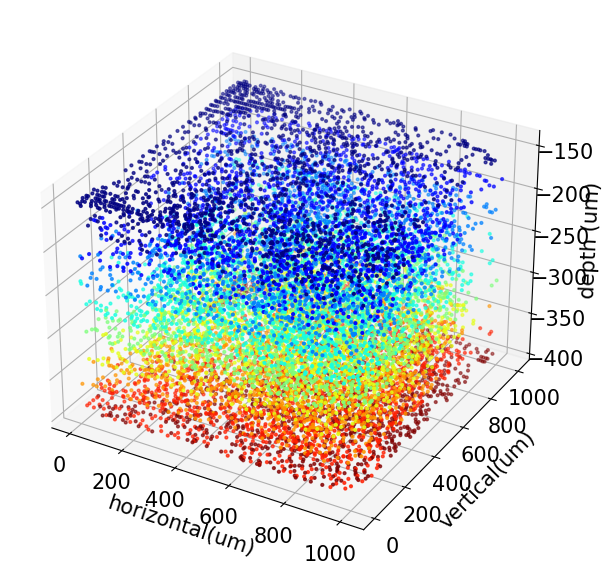

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

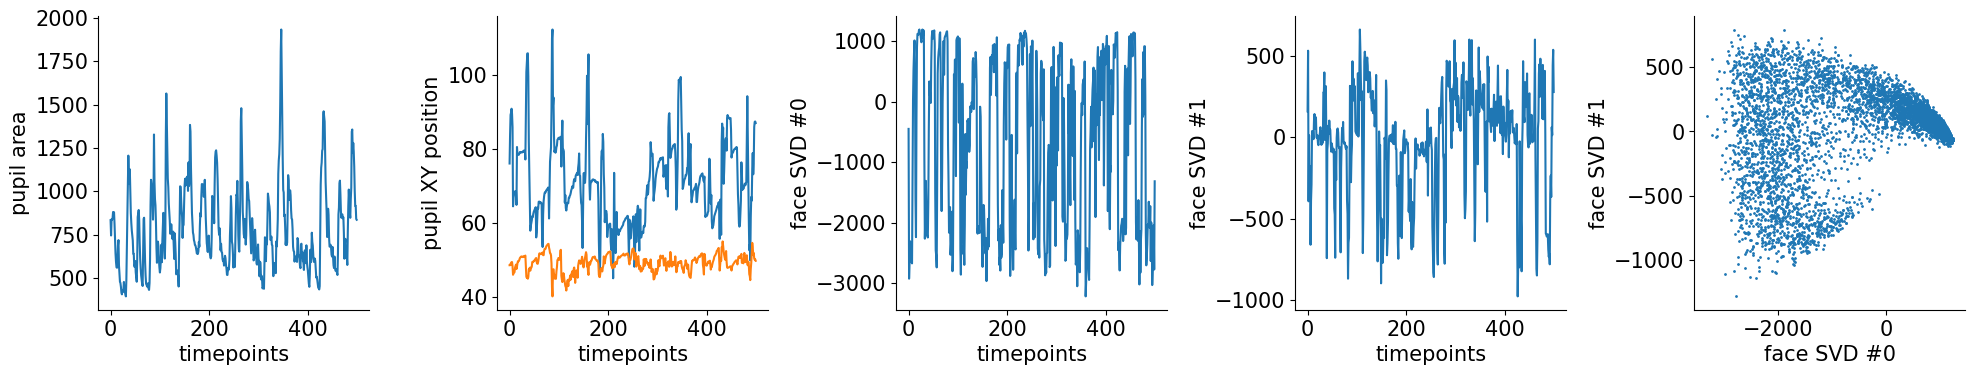

In [ ]:
# @title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupilArea'][:500, 0])
ax.set(xlabel='timepoints', ylabel='pupil area')

ax = plt.subplot(1, 5, 2)
plt.plot(dat['pupilCOM'][:500, :])
ax.set(xlabel='timepoints', ylabel='pupil XY position')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['beh_svd_time'][:500, 0])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['beh_svd_time'][:500, 1])
ax.set(xlabel='timepoints', ylabel='face SVD #1')

ax = plt.subplot(1, 5, 5)
plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
ax.set(xlabel='face SVD #0', ylabel='face SVD #1')

plt.show()

(7018, 1)


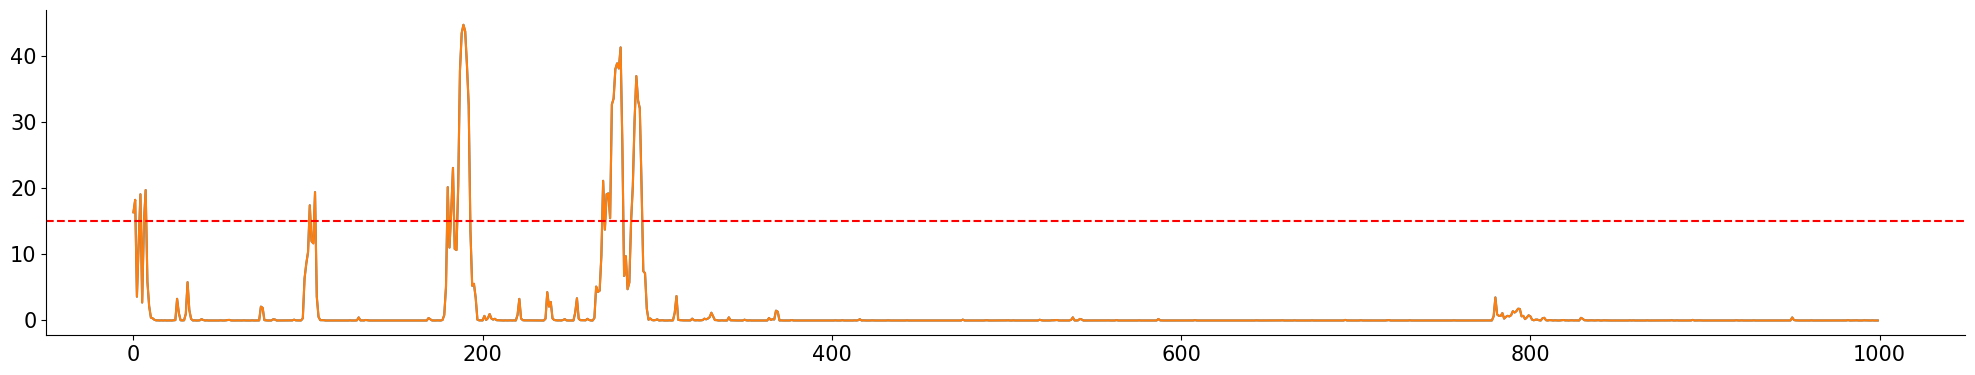

In [ ]:
# @title Smoothing running speed to identify high motion periods during stimuli condition (HMS).
run_data=dat['run']
print(run_data.shape)
plt.plot(run_data[2000:3000])
from scipy.signal import hilbert, convolve
analytic_signal = hilbert(run_data)
envelope = np.abs(analytic_signal)
window_size = 25
#smoothed_envelope_HMS = convolve(envelope, np.ones(window_size) / window_size, mode='same')
smoothed_envelope_HMS=envelope
plt.plot(smoothed_envelope_HMS[2000:3000])
# Add a horizontal line at Threshold
plt.axhline(y=10, color='r', linestyle='--', label='Horizontal Line at y=3')


Text(0.5, 1.0, 'Speed (raw and smoothed) during period of High motion activity')

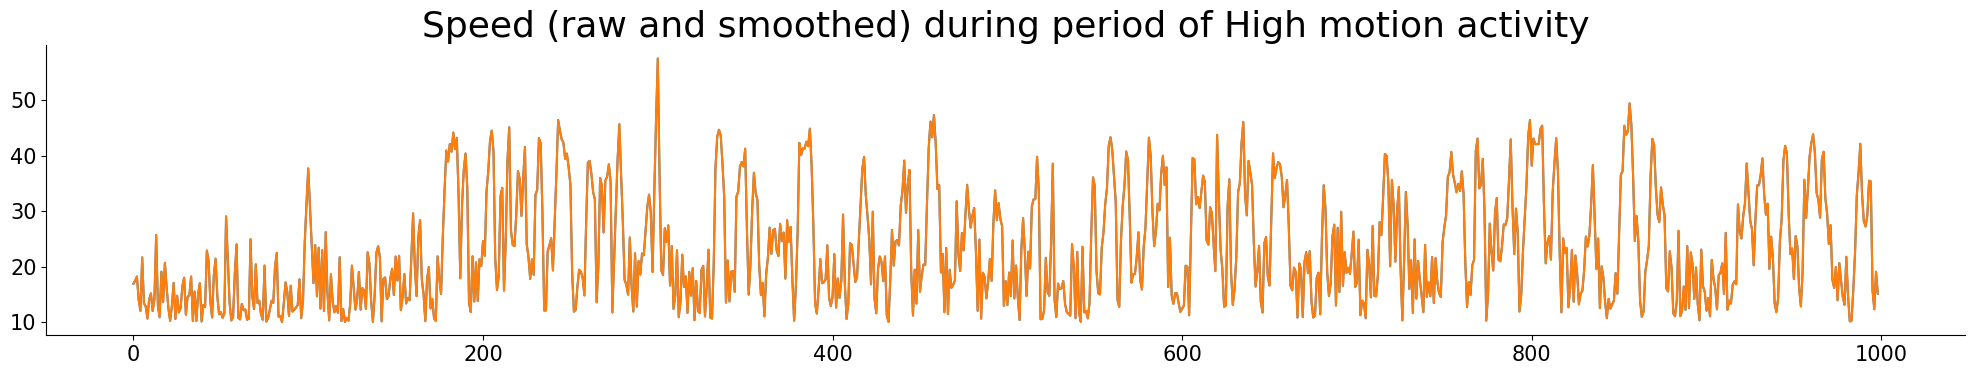

In [ ]:
# @title Thresholding speed to find high motion and low motion periods
threshold = 10
angle_data=dat['pupilArea']

# Threshold the signal
above_threshold = smoothed_envelope_HMS > threshold
below_threshold= smoothed_envelope_HMS<=threshold

# Find the start and end indices of the periods above the threshold
start_indices = np.where(above_threshold & ~np.roll(above_threshold, 1))[0]
end_indices = np.where(above_threshold & ~np.roll(above_threshold, -1))[0]

start_indices_nonmotion = np.where(below_threshold & ~np.roll(below_threshold, 1))[0]
end_indices_nonmotion = np.where(below_threshold & ~np.roll(below_threshold, -1))[0]

# Handle edge case where the first or last point is above the threshold
if above_threshold[0]:
    start_indices = np.concatenate(([0], start_indices))
if above_threshold[-1]:
    end_indices = np.concatenate((end_indices, [len(smoothed_envelope_HMS) - 1]))

# Handle edge case where the first or last point is above the threshold
if below_threshold[0]:
    start_indices_nonmotion = np.concatenate(([0], start_indices_nonmotion))
if below_threshold[-1]:
    end_indices_nonmotion = np.concatenate((end_indices_nonmotion, [len(smoothed_envelope_HMS) - 1]))

# Create a concatenated signal with only the periods above the threshold
high_motion_smoothed_envelope = np.concatenate([smoothed_envelope_HMS[start:end+1] for start, end in zip(start_indices, end_indices)])
high_motion_run_data = np.concatenate([run_data[start:end+1] for start, end in zip(start_indices, end_indices)])
high_motion_angle_data = np.concatenate([angle_data[start:end+1] for start, end in zip(start_indices, end_indices)])



plt.plot(high_motion_smoothed_envelope)
plt.plot(high_motion_run_data)
plt.title('Speed (raw and smoothed) during period of High motion activity', fontsize=26)

(11983, 999)
(11983,)


Text(0.5, 1.0, 'Mean activity across 23589 neurons during High motion period')

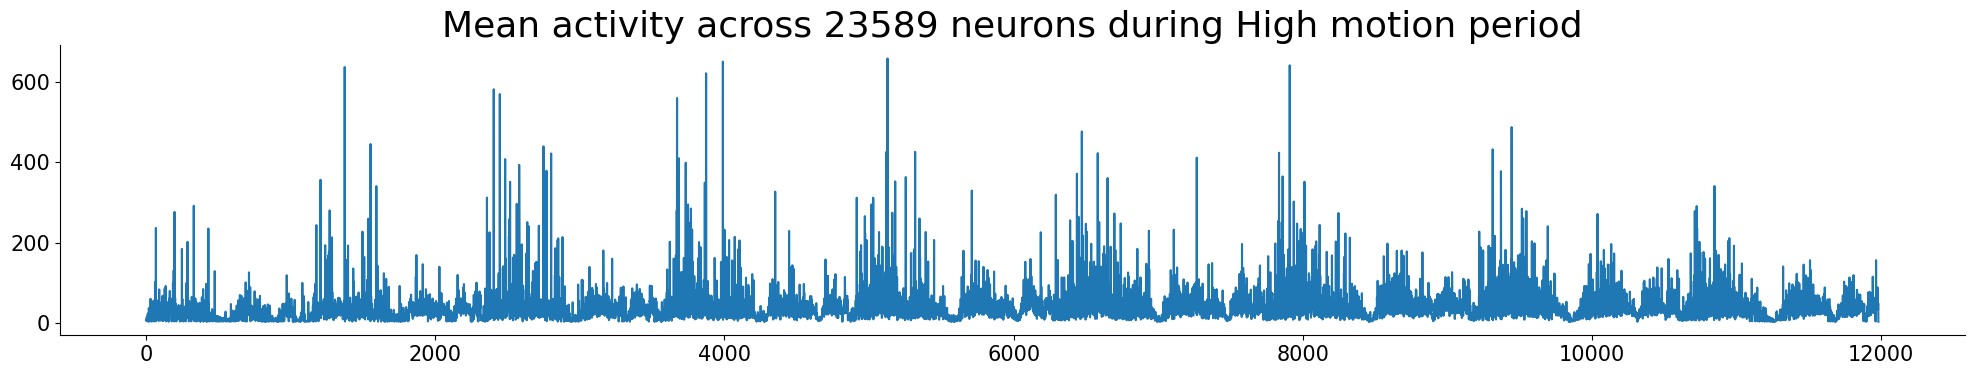

In [ ]:
# @title Extracting neural activity during high motion periods

neural_data=dat['sresp']
high_motion_neural_data = np.concatenate([neural_data[:, start:end+1] for start, end in zip(start_indices, end_indices)], axis=1)
print(high_motion_neural_data.shape)
high_motion_average=np.mean(high_motion_neural_data,axis=1)
print(high_motion_average.shape)
plt.plot(high_motion_average)
plt.title('Mean activity across 11983 neurons during High motion period', fontsize=26)

(11983, 6019)
(11983,)


Text(0.5, 1.0, 'Mean activity across 23589 neurons during Low motion period')

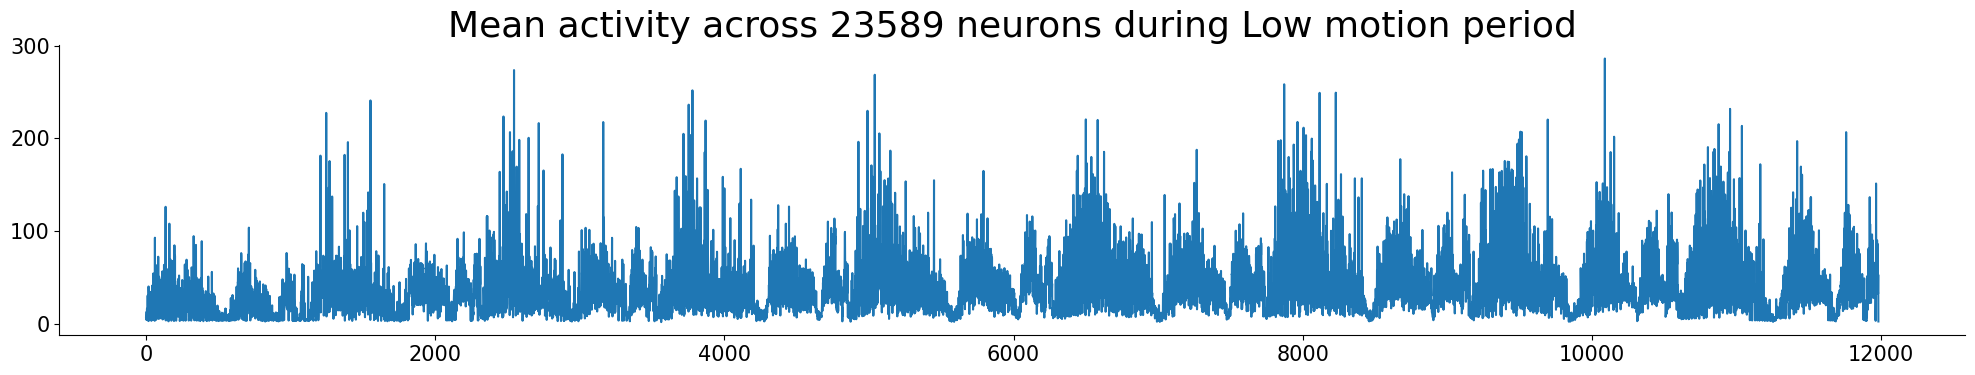

In [ ]:
angle_data=dat['pupilArea']

non_motion_neural_data = np.concatenate([neural_data[:, start:end+1] for start, end in zip(start_indices_nonmotion, end_indices_nonmotion)], axis=1)
non_motion_angle_data=np.concatenate([angle_data[start:end+1] for start, end in zip(start_indices_nonmotion, end_indices_nonmotion)], axis=0)
non_motion_run_data=np.concatenate([run_data[start:end+1] for start, end in zip(start_indices_nonmotion, end_indices_nonmotion)], axis=0)

print(non_motion_neural_data.shape)
#plt.plot(high_motor_neural_data[0,:])
non_motion_average=np.mean(non_motion_neural_data,axis=1)
print(non_motion_average.shape)
plt.plot(non_motion_average)
plt.title('Mean activity across 11983 neurons during Low motion period', fontsize=26)

Text(0.5, 1.0, 'Cortical Depth (Z)')

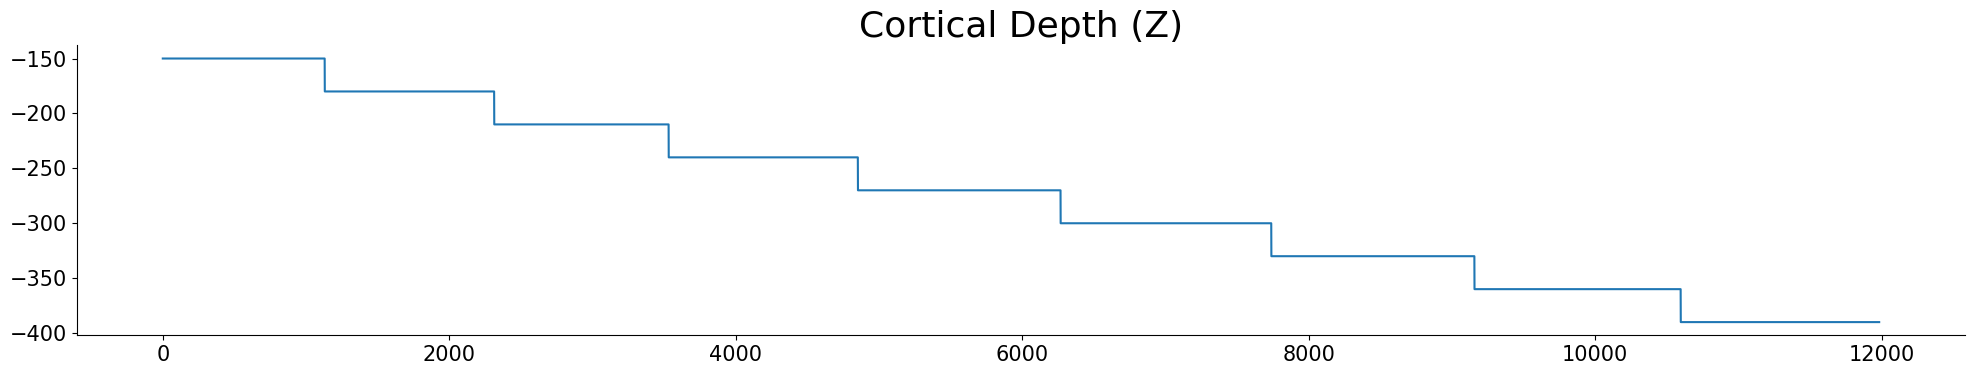

In [ ]:
plt.plot(z)
plt.title('Cortical Depth (Z)', fontsize=26)

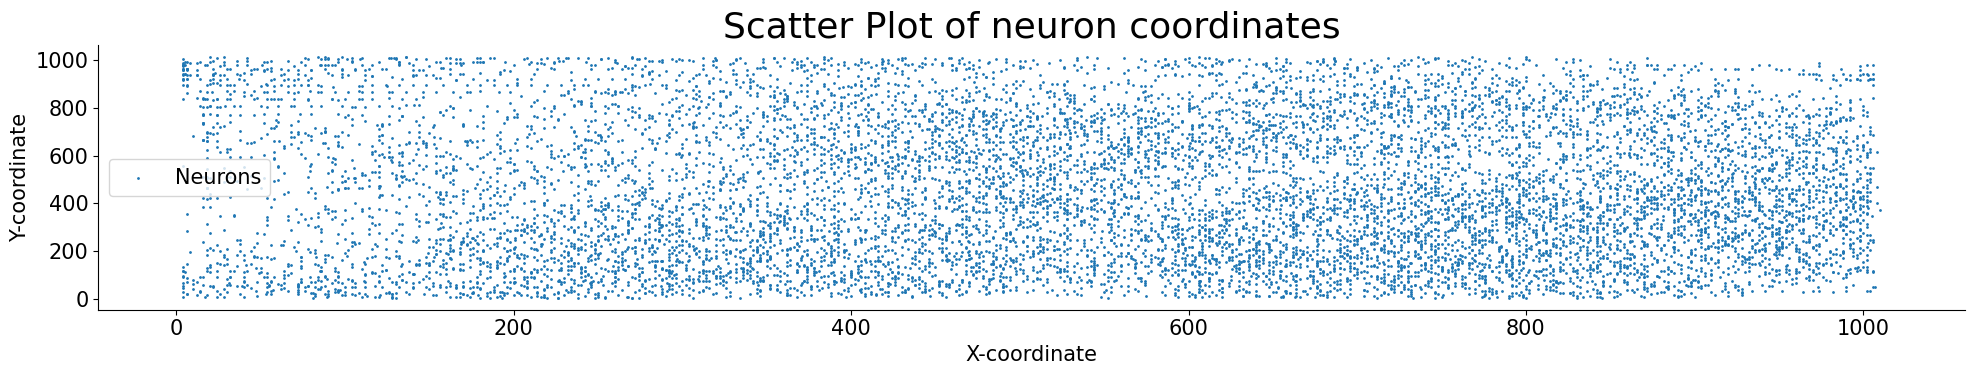

In [ ]:
# @title Distribution of X-Y coordinates

x,y,z=dat['xyz']
# Scatter plot of x-y coordinates
plt.scatter(x, y, label='Neurons',s=1)

# Add labels and title
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Scatter Plot of neuron coordinates',fontsize=26)

# Show the plot
plt.legend()
plt.show()

(11983,)
[False False False ... False False False] 246


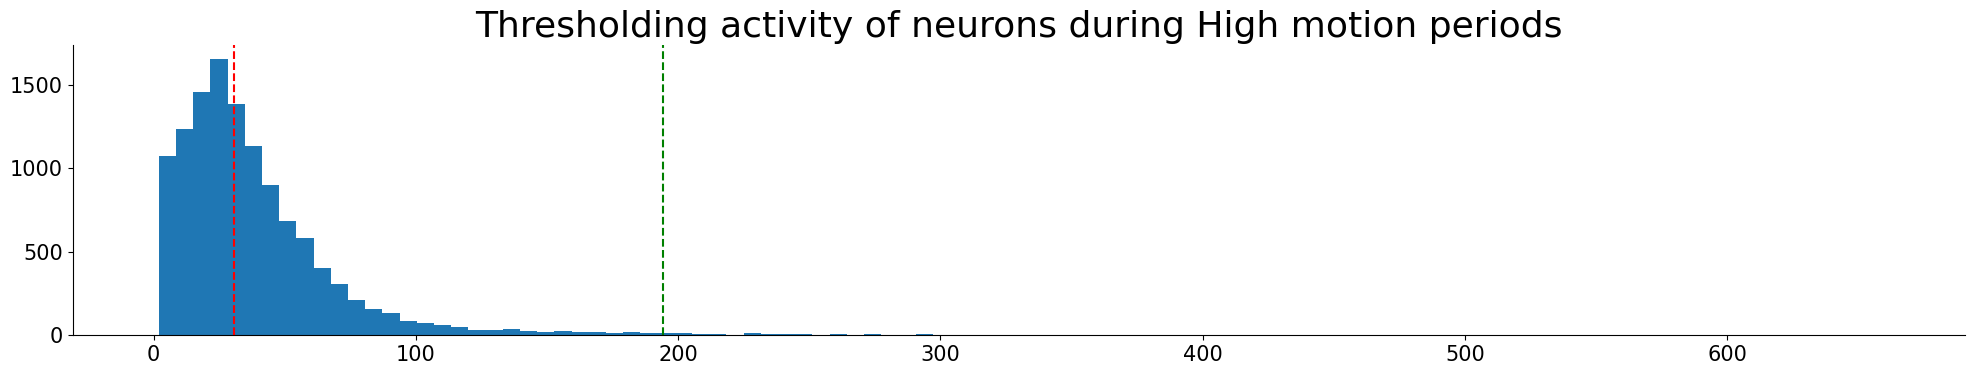

In [ ]:
# @title Finding neurons with high activity during High motion periods

plt.hist(high_motion_average,100)
plt.axvline(x=np.median(high_motion_average), color='r', linestyle='--', label='Vertical Line at y=25')
plt.axvline(x=np.median(high_motion_average)+np.std(high_motion_average)*4, color='g', linestyle='--', label='Vertical Line at y=25')
plt.title('Thresholding activity of neurons during High motion periods',fontsize=26)

threshold_motor_neurons=np.median(high_motion_average)+np.std(high_motion_average)*3
neurons_id=np.arange(0,11983, 1)
print(neurons_id.shape)
# Threshold the neurons
above_threshold = high_motion_average > threshold_motor_neurons
print(above_threshold, np.sum(above_threshold))

motor_neurons=neurons_id[above_threshold]



(11983,)
[False False False ... False False False] 271


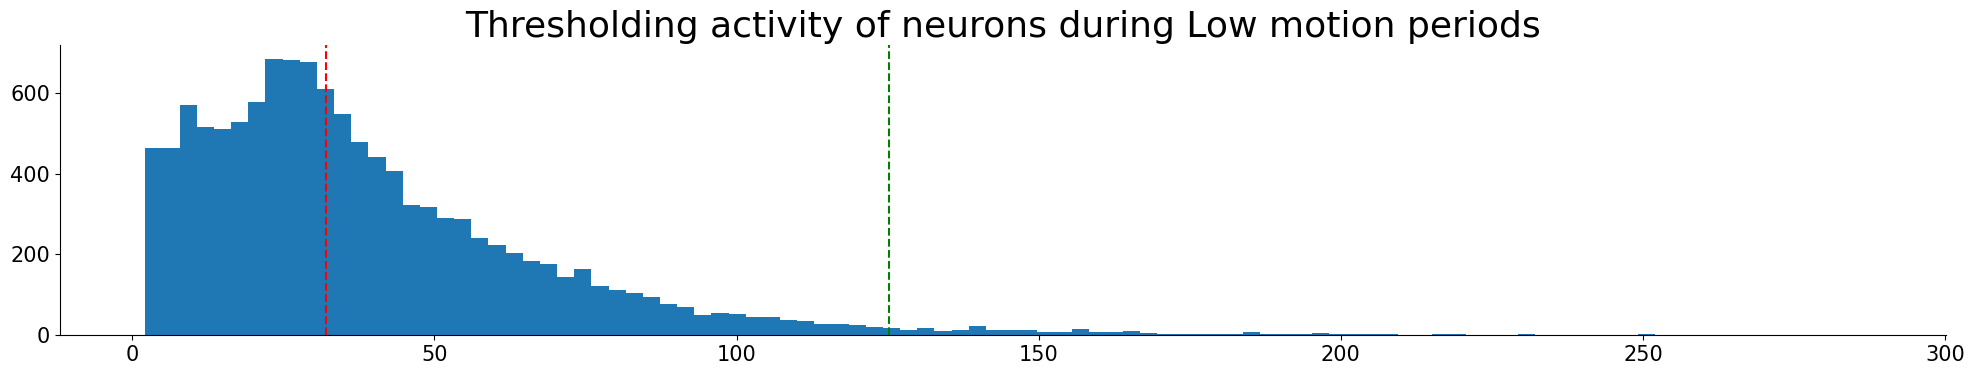

In [ ]:
# @title Finding neurons with high activity during Low motion periods

plt.hist(non_motion_average,100)
plt.axvline(x=np.median(non_motion_average), color='r', linestyle='--', label='Vertical Line at y=25')
plt.axvline(x=np.median(non_motion_average)+np.std(non_motion_average)*3, color='g', linestyle='--', label='Vertical Line at y=25')
plt.title('Thresholding activity of neurons during Low motion periods',fontsize=26)

threshold_non_motor_neurons=np.median(non_motion_average)+np.std(non_motion_average)*3
neurons_id_LMS=np.arange(0, 11983, 1)
print(neurons_id_LMS.shape)
# Threshold the neurons
above_threshold = non_motion_average > threshold_non_motor_neurons
print(above_threshold, np.sum(above_threshold))

LMS_neurons=neurons_id_LMS[above_threshold]

In [ ]:
# @title Finding common neurons in both High motion and Low motion periods
# Find common values
common_values = np.intersect1d(motor_neurons, LMS_neurons)
print(common_values.shape)
# Display the common values
#print("Common Values:", common_values)

# Find non-common values in array1
pure_motor_neurons = np.setdiff1d(motor_neurons, common_values)
print(pure_motor_neurons.shape)
#print(pure_motor_neurons)

pure_non_motor_neurons = np.setdiff1d(LMS_neurons, common_values)
print(pure_non_motor_neurons.shape)
#print(pure_non_motor_neurons)


(92,)
(154,)
(179,)


In [ ]:
pip install matplotlib_venn

In [ ]:
# @title remove common values to obtain pure motor neurons and pure non-motor neurons
LMS_neurons_wo_common = np.setdiff1d(LMS_neurons, common_values)
motor_neurons_wo_common = np.setdiff1d(motor_neurons, common_values)
print(len(LMS_neurons_wo_common))
print(len(motor_neurons_wo_common))
print(len(common_values))
total_number_neurons=len(LMS_neurons_wo_common)+len(motor_neurons_wo_common)+len(common_values)
print(total_number_neurons)

179
154
92
425


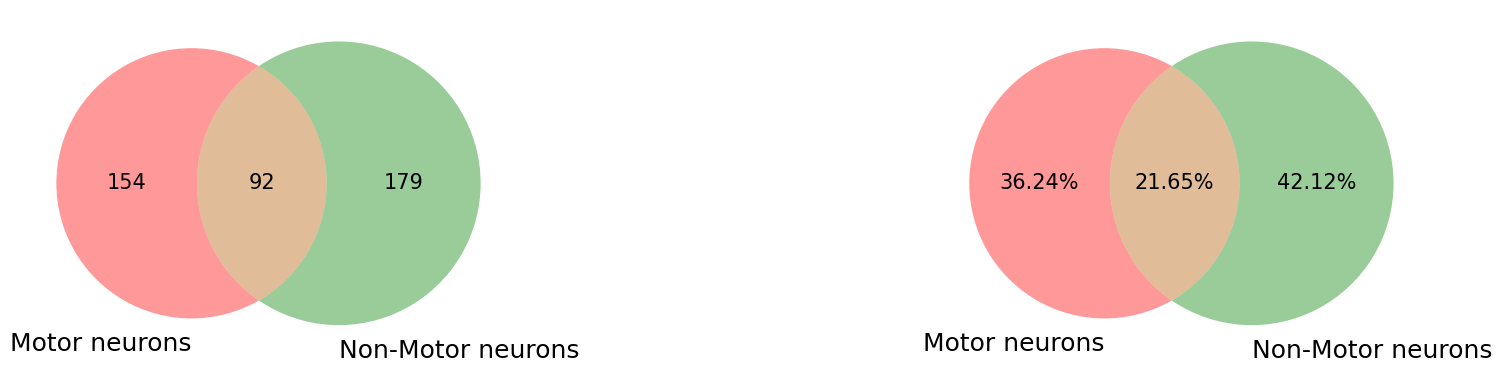

271


In [ ]:
# Set sizes of the groups in the Venn diagram
from matplotlib_venn import venn2
size_array1 = len(motor_neurons)
size_array2 = len(LMS_neurons)
size_common = len(common_values)

plt.subplot(1, 2, 1)
# Create a Venn diagram
venn2(subsets=(size_array1 - size_common, size_array2 - size_common, size_common),
      set_labels=('Motor neurons', 'Non-Motor neurons'))
plt.subplot(1, 2, 2)
venn2(subsets=(size_array1 - size_common, size_array2 - size_common, size_common),
      set_labels=('Motor neurons', 'Non-Motor neurons'),subset_label_formatter=lambda x: f"{ (x/total_number_neurons):1.2%}")

# Display the plot
plt.show()
print(len(LMS_neurons))

377 common neurons with high activity independently of speed

In [ ]:
Z = zscore(non_motion_neural_data[LMS_neurons_wo_common], axis=1)
Z.shape

(179, 6019)

In [ ]:
# @title take PCA to obtain PC per neuron group

Z = zscore(non_motion_neural_data[LMS_neurons_wo_common], axis=1)
#X_non_motor = PCA(n_components=20).fit_transform(Z.T)
# Create and fit the PCA model
pca = PCA(n_components=135)
X_non_motor = pca.fit_transform(Z.T)
# Get the explained variance from the PCA model
explained_variance = pca.explained_variance_ratio_
print("Explained Variance cumulative sum:", np.cumsum(explained_variance))

Z = zscore(high_motion_neural_data[motor_neurons_wo_common], axis=1)
pca = PCA(n_components=100)
#X_motor = PCA(n_components=20).fit_transform(Z.T)
X_motor = pca.fit_transform(Z.T)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance cumulative sum:", np.cumsum(explained_variance))

Z = zscore(non_motion_neural_data[common_values], axis=1)
pca = PCA(n_components=70)
#X_common_non_motor = PCA(n_components=20).fit_transform(Z.T)
X_common_non_motor = pca.fit_transform(Z.T)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance cumulative sum:", np.cumsum(explained_variance))


Z = zscore(high_motion_neural_data[common_values], axis=1)
pca = PCA(n_components=65)
#X_common_motor = PCA(n_components=20).fit_transform(Z.T)
X_common_motor = pca.fit_transform(Z.T)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance cumulative sum:", np.cumsum(explained_variance))



Explained Variance cumulative sum: [0.06191604 0.1088241  0.14743647 0.17198771 0.19331032 0.21333005
 0.23070656 0.24510899 0.25928238 0.27224827 0.28431773 0.29595575
 0.30746904 0.31869766 0.32913342 0.33911806 0.34861293 0.3577413
 0.36654025 0.37508056 0.38338172 0.39158702 0.39958647 0.40743682
 0.4152831  0.4229048  0.43030852 0.43753126 0.4446219  0.45152855
 0.45840296 0.46505278 0.47164235 0.47816813 0.48459324 0.4908857
 0.4970332  0.5031161  0.50907326 0.51500785 0.52090245 0.5267176
 0.5324241  0.53809994 0.54369783 0.5492177  0.55471945 0.5601519
 0.5655091  0.57077885 0.5760432  0.58118284 0.5863056  0.5914276
 0.5965109  0.6015513  0.6065368  0.61145353 0.6163473  0.6211613
 0.62594193 0.63068604 0.6354086  0.64003193 0.6446321  0.6492209
 0.6537843  0.6582803  0.66275847 0.6671766  0.6715715  0.6759416
 0.6802676  0.68453944 0.6887993  0.69303834 0.6972531  0.7014336
 0.70558995 0.7097311  0.7138599  0.71792775 0.72198796 0.72600085
 0.73000675 0.7339582  0.73788315 0.

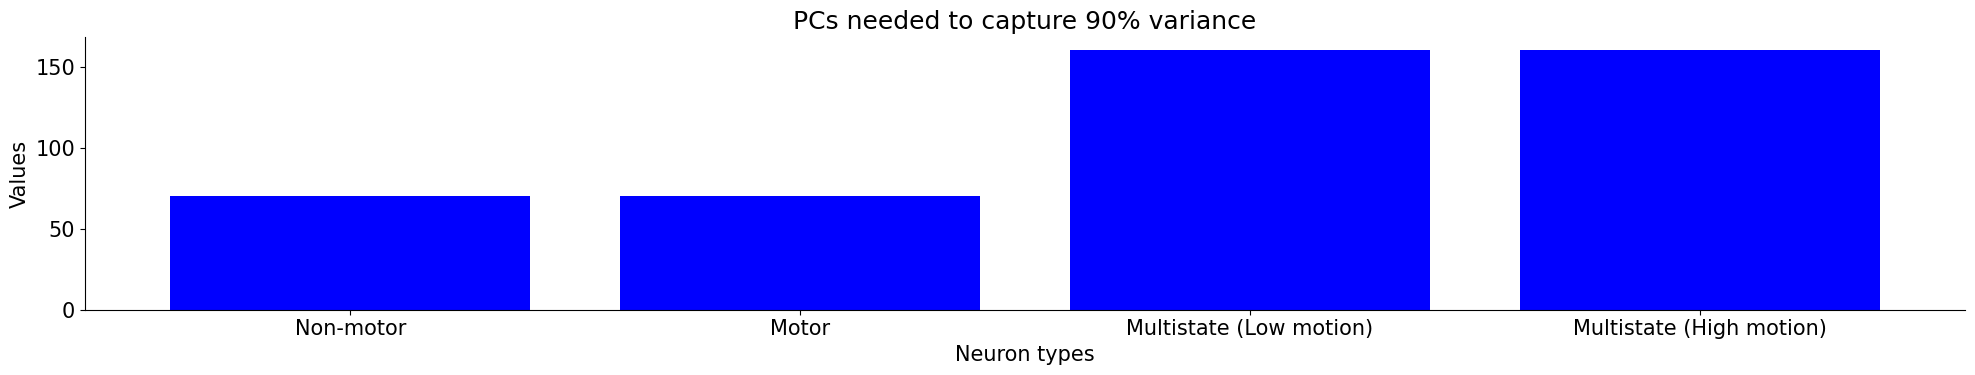

In [ ]:

# Sample data
categories = ['Non-motor', 'Motor', 'Multistate (Low motion)', 'Multistate (High motion)']
values1 = [70, 70, 160, 160]

# Create a bar plot
plt.bar(categories, values1, color='blue')

# Add labels and title
plt.xlabel('Neuron types')
plt.ylabel('Values')
plt.title('PCs needed to capture 90% variance')

# Display the plot
plt.show()



In [ ]:
print(high_motion_run_data.shape)
print(X_motor[:,i].shape)
np.corrcoef(np.squeeze(high_motion_run_data),X_motor[:,i])

(999, 1)
(999,)


array([[ 1.        , -0.06279616],
       [-0.06279616,  1.        ]])

Multistate neurons have a higher complexity compared to non-motor and motor neurons.

4 PCA's:


*   Motor neurons (X_motor)
*   Non-motor neurons (X_non_motor)
*   Common neurons during High Motion periods (X_common_motor)
*   Common neurons during Low Motion periods (X_common_non_motor)




In [ ]:
#Motor
high_motion_run_data=np.squeeze(high_motion_run_data);

# @title Motor neurons: We iterate across the PCs to find the one with the highest correlation to the running speed
pc_highestcorr=0;
for i in range(X_motor.shape[1]):
  xx=np.abs(np.corrcoef(high_motion_run_data,X_motor[:,i])[1,0])
  #print(xx)
  if xx > pc_highestcorr:
    pc_highestcorr=xx
    pc_ind=i
print(pc_ind)
print(np.corrcoef(high_motion_run_data,X_motor[:,pc_ind])[1,0])
X_motor_pc=X_motor[:,pc_ind]

2
-0.5847984975121979


In [ ]:
print(X_motor.shape)
print(high_motion_run_data.shape)

(999, 100)
(999,)


In [ ]:
#Non-Motor
non_motion_angle_data=np.squeeze(non_motion_angle_data)
# @title Non-Motor neurons: We iterate across the PCs to find the one with the highest correlation to the stimulation angle
pc_highestcorr=0;
for i in range(X_non_motor.shape[1]):
  xx=np.abs(np.corrcoef(non_motion_angle_data,X_non_motor[:,i])[1,0])
  #print(xx)
  if xx > pc_highestcorr:
    pc_highestcorr=xx
    pc_ind=i
print(pc_ind)
print(np.corrcoef(non_motion_angle_data,X_non_motor[:,pc_ind])[1,0])
X_non_motor_pc=X_non_motor[:,pc_ind]

0
0.5036135040101449


In [ ]:
print(X_non_motor.shape)
print(non_motion_angle_data.shape)

(6019, 135)
(6019,)


In [ ]:
#Motor
# @title Common neurons during High Motion period: We iterate across the PCs to find the one with the highest correlation to the running speed
pc_highestcorr=0;
for i in range(X_common_motor.shape[1]):
  xx=np.abs(np.corrcoef(high_motion_run_data,X_common_motor[:,i])[1,0])
  #print(xx)
  if xx > pc_highestcorr:
    pc_highestcorr=xx
    pc_ind=i
print(pc_ind)
print(np.corrcoef(high_motion_run_data,X_common_motor[:,pc_ind])[1,0])
X_common_motor_pc=X_common_motor[:,pc_ind]

0
-0.45756438946418726


In [ ]:
print(X_common_motor.shape)
print(high_motion_run_data.shape)

(999, 65)
(999,)


In [ ]:
#Non Motor
# @title Common neurons during Low Motion period: We iterate across the PCs to find the one with the highest correlation to the stimulation angle
pc_highestcorr=0;
for i in range(X_common_non_motor.shape[1]):
  xx=np.abs(np.corrcoef(non_motion_angle_data,X_common_non_motor[:,i])[1,0])
  #print(xx)
  if xx > pc_highestcorr:
    pc_highestcorr=xx
    pc_ind=i
print(pc_ind)
print(np.corrcoef(non_motion_angle_data,X_common_non_motor[:,pc_ind])[1,0])
X_common_non_motor_pc=X_common_non_motor[:,pc_ind]*-1 #Multiplied by -1 to reverse correlation sign

0
0.6356386985211767


4 PC's per neuron type (Selected based on correlation with speed or angle):


*   Motor neurons (X_motor_pc)
*   Non-motor neurons (X_non_motor_pc)
*   Common neurons during High Motor periods (X_common_motor_pc)
*   Common neurons during Low Motor periods (X_common_non_motor_pc)



In [ ]:
print(X_motor_pc.shape)
print(X_non_motor_pc.shape)
print(X_common_motor_pc.shape)
print(X_common_non_motor_pc.shape)


(999,)
(6019,)
(999,)
(6019,)


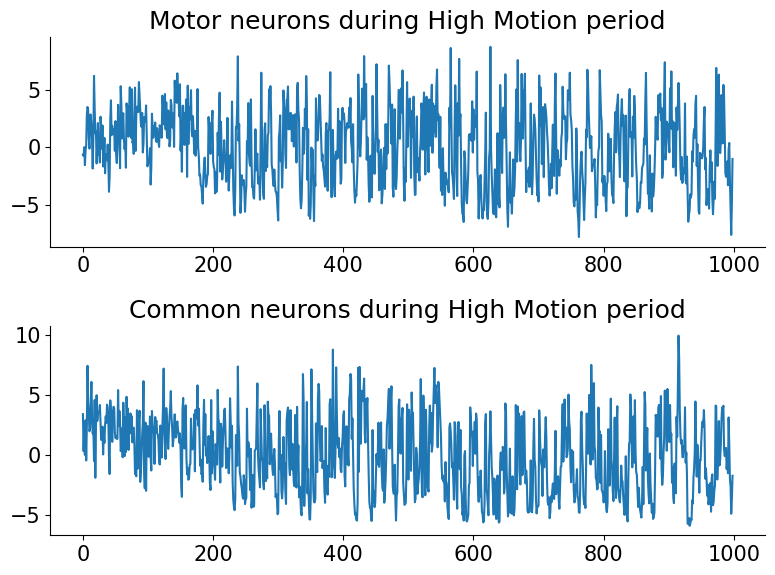

0.6503795389988646


In [ ]:
# @title Motor and common neurons during High motion period
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot the data in the first subplot
axs[0].plot(X_motor_pc)
axs[0].set_title('Motor neurons during High Motion period')

# Plot the data in the second subplot
axs[1].plot(X_common_motor_pc)
axs[1].set_title('Common neurons during High Motion period')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
print(np.corrcoef(X_motor_pc,X_common_motor_pc)[1,0])

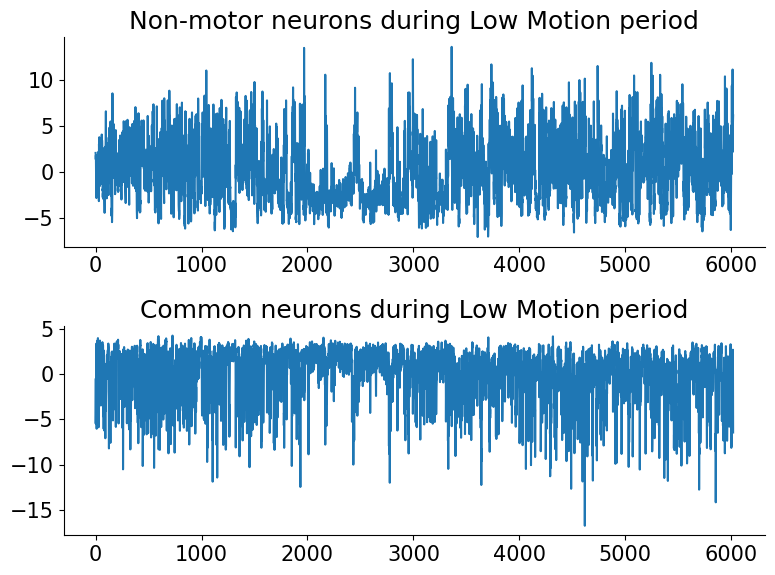

-0.42470098163276915


In [ ]:
# @title Non-motor and common neurons during Low motion period
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot the data in the first subplot
axs[0].plot(X_non_motor_pc)
axs[0].set_title('Non-motor neurons during Low Motion period')

# Plot the data in the second subplot
axs[1].plot(X_common_non_motor_pc)
axs[1].set_title('Common neurons during Low Motion period')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
print(np.corrcoef(X_non_motor_pc,X_common_non_motor_pc)[1,0])

In [ ]:
# @title Functions to perform regression (Linear, polynomial ) and obtain null distribution
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

def linear_reg(X,y,num_splits=10):
  # Check if X is 1D, reshape if needed
  if len(X.shape) == 1:
        X = X.reshape(-1, 1)
  mse_values=[];
  for i in range(num_splits):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42+i)
    #print("X_train",X_train.shape)
    #print("y_train",y_train.shape)
    # Initialize and train the model
    model = LinearRegression()
    #model.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))
    model.fit(X_train, y_train)

    # Make predictions on the test set
    #predictions = model.predict(X_test.reshape(-1, 1))
    predictions = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    mse_values.append(mse)
  #print(f"Mean Squared Error: {mse}")
  return(mse_values)


def poli_reg(X, y, degree,num_splits=10):
    # Check if X is 1D, reshape if needed
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    mse_values=[];
    for i in range(num_splits):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42+i)

      # Create polynomial features
      poly = PolynomialFeatures(degree=degree)
      X_poly_train = poly.fit_transform(X_train)
      X_poly_test = poly.transform(X_test)

      # Train linear regression model
      model = LinearRegression()
      model.fit(X_poly_train, y_train)

      # Make predictions
      predictions = model.predict(X_poly_test)

      # Evaluate the model
      mse = mean_squared_error(y_test, predictions)
      mse_values.append(mse)
    return mse_values

def get_null(X_motor_pc):
  num_seeds = 10

  # List to store mean squared errors for each seed
  mse_null_X_motor_pc = []

  # Loop over different random seeds
  for seed_value in range(num_seeds):
      np.random.seed(seed_value)  # Set a different seed in each iteration
      shuffled_array = np.copy(X_motor_pc)  # Make a copy to keep the original array intact
      np.random.shuffle(shuffled_array)

      # Calculate mean squared error
      mse = mean_squared_error(X_motor_pc, shuffled_array)
      mse_null_X_motor_pc.append(mse)
  return mse_null_X_motor_pc


In [ ]:
# @title Compute regression for motor and common neurons during High-motion periods

def compute_models(high_motion_run_data,high_motion_angle_data, X_motor_pc):
  high_motion_combined = np.vstack((high_motion_run_data, high_motion_angle_data)).T # Run and angle combined data

  # List to store MSE values for each model
  mse_values = []

  mse_motor_lineal_run=linear_reg(high_motion_run_data,X_motor_pc)
  mse_values.append(('Linear RUN', np.median(mse_motor_lineal_run)))

  mse_motor_lineal_angle=linear_reg(high_motion_angle_data,X_motor_pc)
  mse_values.append(('Linear Angle', np.median(mse_motor_lineal_angle)))

  mse_motor_lineal_multinput=linear_reg(high_motion_combined,X_motor_pc)
  mse_values.append(('Linear Multi', np.median(mse_motor_lineal_multinput)))

  degree = 2
  mse_motor_poli2_run = poli_reg(high_motion_run_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} RUN', np.median(mse_motor_poli2_run)))

  mse_motor_poli2_angle = poli_reg(high_motion_angle_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Angle', np.median(mse_motor_poli2_angle)))

  mse_motor_poli2_multinput = poli_reg(high_motion_combined, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Multi', np.median(mse_motor_poli2_multinput)))


  degree = 3
  mse_motor_poli3_run = poli_reg(high_motion_run_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} RUN', np.median(mse_motor_poli3_run)))

  mse_motor_poli3_angle = poli_reg(high_motion_angle_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Angle', np.median(mse_motor_poli3_angle)))

  mse_motor_poli3_multinput = poli_reg(high_motion_combined, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Multi', np.median(mse_motor_poli3_multinput)))


  degree = 4
  mse_motor_poli4_run = poli_reg(high_motion_run_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} RUN', np.median(mse_motor_poli4_run)))

  mse_motor_poli4_angle = poli_reg(high_motion_angle_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Angle', np.median(mse_motor_poli4_angle)))

  mse_motor_poli4_multinput = poli_reg(high_motion_combined, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Multi', np.median(mse_motor_poli4_multinput)))


  degree = 5
  mse_motor_poli5_run = poli_reg(high_motion_run_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} RUN', np.median(mse_motor_poli5_run)))

  mse_motor_poli5_angle = poli_reg(high_motion_angle_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Angle', np.median(mse_motor_poli5_angle)))

  mse_motor_poli5_multinput = poli_reg(high_motion_combined, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Multi', np.median(mse_motor_poli5_multinput)))



  # Find the model with the minimum MSE
  best_model_name, min_mse = min(mse_values, key=lambda x: x[1])

  # Print or return the results
  print(f'The best model is: {best_model_name} with MSE: {min_mse}')



  return mse_values,mse_motor_lineal_run,mse_motor_lineal_angle, mse_motor_lineal_multinput, mse_motor_poli2_run,mse_motor_poli2_angle,mse_motor_poli2_multinput,mse_motor_poli3_run,mse_motor_poli3_angle,mse_motor_poli3_multinput,mse_motor_poli4_run,mse_motor_poli4_angle,mse_motor_poli4_multinput,mse_motor_poli5_run,mse_motor_poli5_angle,mse_motor_poli5_multinput

print('motor neurons')
high_motion_angle_data=np.squeeze(high_motion_angle_data)
result=compute_models(high_motion_run_data,high_motion_angle_data, X_motor_pc)
mse_allmodels_motor_pc, mse_motor_lineal_run, mse_motor_lineal_angle,mse_motor_lineal_multinput, mse_motor_poli2_run,mse_motor_poli2_angle,mse_motor_poli2_multinput,mse_motor_poli3_run,mse_motor_poli3_angle,mse_motor_poli3_multinput,mse_motor_poli4_run,mse_motor_poli4_angle,mse_motor_poli4_multinput,mse_motor_poli5_run,mse_motor_poli5_angle,mse_motor_poli5_multinput = result;
#mse_values,mse_motor_lineal_run,mse_motor_lineal_angle, mse_motor_lineal_multinput, mse_motor_poli2_run,mse_motor_poli2_angle,mse_motor_poli2_multinput,mse_motor_poli3_run,mse_motor_poli3_angle,mse_motor_poli3_multinput,mse_motor_poli4_run,mse_motor_poli4_angle,mse_motor_poli4_multinput,mse_motor_poli5_run,mse_motor_poli5_angle,mse_motor_poli5_multinput

print('common neurons during high motion period')
result=compute_models(high_motion_run_data,high_motion_angle_data, X_common_motor_pc)
#mse_allmodels_common_motor_pc,mse_common_motor_lineal_singleinput, mse_common_motor_lineal_multinput, mse_common_motor_poli2_singleinput,mse_common_motor_poli2_multinput,mse_common_motor_poli3_singleinput,mse_common_motor_poli3_multinput,mse_common_motor_poli4_singleinput,mse_common_motor_poli4_multinput,mse_common_motor_poli5_singleinput,mse_common_motor_poli5_multinput = result;
mse_allmodels_common_motor_pc, mse_common_motor_lineal_run, mse_common_motor_lineal_angle,mse_common_motor_lineal_multinput, mse_common_motor_poli2_run,mse_common_motor_poli2_angle,mse_common_motor_poli2_multinput,mse_common_motor_poli3_run,mse_common_motor_poli3_angle,mse_common_motor_poli3_multinput,mse_common_motor_poli4_run,mse_common_motor_poli4_angle,mse_common_motor_poli4_multinput,mse_common_motor_poli5_run,mse_common_motor_poli5_angle,mse_common_motor_poli5_multinput = result;

non_motion_run_data=np.squeeze(non_motion_run_data)
print('common neurons during low motion period')
result=compute_models(non_motion_run_data, non_motion_angle_data, X_common_non_motor_pc)
#mse_allmodels_common_non_motor_pc,mse_common_non_motor_lineal_singleinput, mse_common_non_motor_lineal_multinput, mse_common_non_motor_poli2_singleinput,mse_common_non_motor_poli2_multinput,mse_common_non_motor_poli3_singleinput,mse_common_non_motor_poli3_multinput,mse_common_non_motor_poli4_singleinput,mse_common_non_motor_poli4_multinput,mse_common_non_motor_poli5_singleinput,mse_common_non_motor_poli5_multinput = result;
mse_allmodels_common_non_motor_pc, mse_common_non_motor_lineal_run, mse_common_non_motor_lineal_angle,mse_common_non_motor_lineal_multinput, mse_common_non_motor_poli2_run,mse_common_non_motor_poli2_angle,mse_common_non_motor_poli2_multinput,mse_common_non_motor_poli3_run,mse_common_non_motor_poli3_angle,mse_common_non_motor_poli3_multinput,mse_common_non_motor_poli4_run,mse_common_non_motor_poli4_angle,mse_common_non_motor_poli4_multinput,mse_common_non_motor_poli5_run,mse_common_non_motor_poli5_angle,mse_common_non_motor_poli5_multinput = result;


print('non-motor neurons during low motion period')
result=compute_models(non_motion_run_data, non_motion_angle_data,X_non_motor_pc)
#mse_allmodels_non_motor_pc,mse_non_motor_lineal_singleinput, mse_non_motor_lineal_multinput, mse_non_motor_poli2_singleinput,mse_non_motor_poli2_multinput,mse_non_motor_poli3_singleinput,mse_non_motor_poli3_multinput,mse_non_motor_poli4_singleinput,mse_non_motor_poli4_multinput,mse_non_motor_poli5_singleinput,mse_non_motor_poli5_multinput = result;
mse_allmodels_non_motor_pc, mse_non_motor_lineal_run, mse_non_motor_lineal_angle,mse_non_motor_lineal_multinput, mse_non_motor_poli2_run,mse_non_motor_poli2_angle,mse_non_motor_poli2_multinput,mse_non_motor_poli3_run,mse_non_motor_poli3_angle,mse_non_motor_poli3_multinput,mse_non_motor_poli4_run,mse_non_motor_poli4_angle,mse_non_motor_poli4_multinput,mse_non_motor_poli5_run,mse_non_motor_poli5_angle,mse_non_motor_poli5_multinput = result;



motor neurons
The best model is: Poly 3 Multi with MSE: 5.924569818084482
common neurons during high motion period
The best model is: Poly 3 Multi with MSE: 6.724156029194141
common neurons during low motion period
The best model is: Poly 4 Multi with MSE: 3.1966769413931515
non-motor neurons during low motion period
The best model is: Poly 4 Multi with MSE: 7.497597334595136


In [ ]:
mse_allmodels_motor_pc

[('Linear RUN', 6.466076009803285),
 ('Linear Angle', 9.132645662598819),
 ('Linear Multi', 6.398069555868951),
 ('Poly 2 RUN', 6.437750497832036),
 ('Poly 2 Angle', 9.121079035185371),
 ('Poly 2 Multi', 6.169525841083427),
 ('Poly 3 RUN', 6.386177749954682),
 ('Poly 3 Angle', 9.0483251944544),
 ('Poly 3 Multi', 5.924569818084482),
 ('Poly 4 RUN', 6.401074887719803),
 ('Poly 4 Angle', 9.07054370759),
 ('Poly 4 Multi', 6.064957399328339),
 ('Poly 5 RUN', 6.406264963226279),
 ('Poly 5 Angle', 9.07150850612327),
 ('Poly 5 Multi', 5.9708118995302275)]

Notice how training Motor neurons with only with the ANGLE led to high error values. Combined ANGLE+RUN reduced the errors.



In [ ]:
mse_allmodels_non_motor_pc

[('Linear RUN', 10.458949370458795),
 ('Linear Angle', 8.126903812100277),
 ('Linear Multi', 8.125356918517017),
 ('Poly 2 RUN', 9.812152676979572),
 ('Poly 2 Angle', 7.954445655489701),
 ('Poly 2 Multi', 7.747031194861796),
 ('Poly 3 RUN', 9.52954873474822),
 ('Poly 3 Angle', 7.958614741384228),
 ('Poly 3 Multi', 7.52469171581493),
 ('Poly 4 RUN', 9.307256376706427),
 ('Poly 4 Angle', 7.902226910299111),
 ('Poly 4 Multi', 7.497597334595136),
 ('Poly 5 RUN', 9.137662235866568),
 ('Poly 5 Angle', 7.891928334815978),
 ('Poly 5 Multi', 7.513030465544284)]

Notice how training Non-motor neurons only with RUN led to high error values. Adding combined Angle+RUN worsens predictions.

In [ ]:
mse_allmodels_common_motor_pc

[('Linear RUN', 7.320072949837647),
 ('Linear Angle', 7.939393113246833),
 ('Linear Multi', 6.934781642488932),
 ('Poly 2 RUN', 7.328478151105658),
 ('Poly 2 Angle', 7.845491803664062),
 ('Poly 2 Multi', 6.99083183818632),
 ('Poly 3 RUN', 7.416676884722965),
 ('Poly 3 Angle', 7.747214073008261),
 ('Poly 3 Multi', 6.724156029194141),
 ('Poly 4 RUN', 7.473711657503216),
 ('Poly 4 Angle', 7.760952444717557),
 ('Poly 4 Multi', 6.93264837033495),
 ('Poly 5 RUN', 7.48507701318999),
 ('Poly 5 Angle', 7.759093685051575),
 ('Poly 5 Multi', 7.058155752861925)]

Common neurons during High motion periods show a high error when using only Angle. Combining Angle+RUN led to an improvement.

In [ ]:
mse_allmodels_common_non_motor_pc

[('Linear RUN', 5.212308717029533),
 ('Linear Angle', 4.744481417891555),
 ('Linear Multi', 3.8358403864964243),
 ('Poly 2 RUN', 4.529097663093932),
 ('Poly 2 Angle', 4.728498692936573),
 ('Poly 2 Multi', 3.4331527449498864),
 ('Poly 3 RUN', 4.319325355609428),
 ('Poly 3 Angle', 4.674669077886001),
 ('Poly 3 Multi', 3.358929051153292),
 ('Poly 4 RUN', 4.090425644727623),
 ('Poly 4 Angle', 4.65132940245766),
 ('Poly 4 Multi', 3.1966769413931515),
 ('Poly 5 RUN', 4.003144156536892),
 ('Poly 5 Angle', 4.653849872412962),
 ('Poly 5 Multi', 3.22304076371692)]

Notice how Common neurons during Low motion period show a higher error when only RUN is used. Combining RUN+Angle led to improvements.

In [ ]:
# @title Null distributions
mse_null_X_motor_pc=get_null(X_motor_pc)
mse_null_X_common_motor_pc=get_null(X_common_motor_pc)
mse_null_X_common_non_motor_pc=get_null(X_common_non_motor_pc)
mse_null_X_non_motor_pc=get_null(X_non_motor_pc)

print('Null error Motor neurons:',np.median(mse_null_X_motor_pc))
print('Null error Common neurons during High motion:',np.median(mse_null_X_common_motor_pc))
print('Null error Common neurons during Low motion:',np.median(mse_null_X_common_non_motor_pc))
print('Null error Non-Motor neurons:',np.median(mse_null_X_non_motor_pc))


Null error Motor neurons: 20.374
Null error Common neurons during High motion: 19.226961
Null error Common neurons during Low motion: 15.976179
Null error Non-Motor neurons: 22.15662


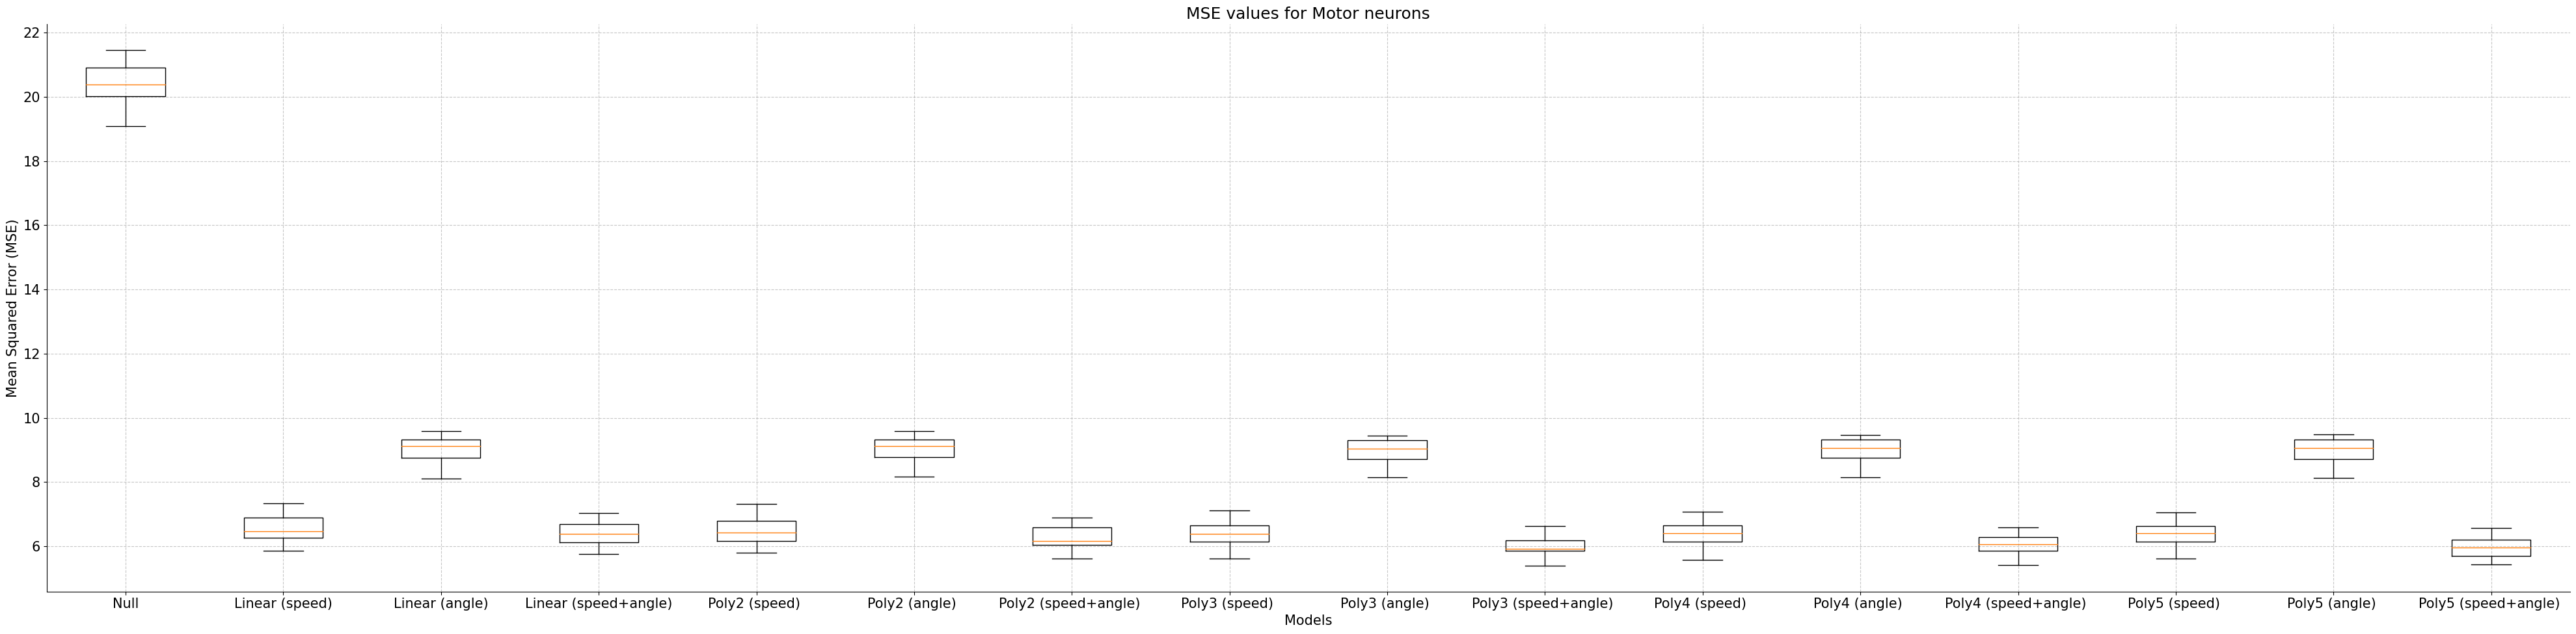

In [ ]:
# Combine the MSE values into a list of lists
#all_mse_values = [mse_null_X_motor_pc, mse_motor_lineal_run, mse_motor_lineal_multinput, mse_motor_poli2_run, mse_motor_poli2_multinput, mse_motor_poli3_run, mse_motor_poli3_multinput, mse_motor_poli4_run, mse_motor_poli4_multinput, mse_motor_poli5_run, mse_motor_poli5_multinput]
all_mse_values = [mse_null_X_motor_pc, mse_motor_lineal_run,mse_motor_lineal_angle, mse_motor_lineal_multinput, mse_motor_poli2_run,mse_motor_poli2_angle, mse_motor_poli2_multinput, mse_motor_poli3_run,mse_motor_poli3_angle, mse_motor_poli3_multinput, mse_motor_poli4_run,mse_motor_poli4_angle, mse_motor_poli4_multinput, mse_motor_poli5_run,mse_motor_poli5_angle, mse_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
#plt.boxplot(all_mse_values, labels=['Null','Linear (speed)', 'Linear (speed+angle)', 'Poly2 (speed) ','Poly2 (speed+angle) ', 'Poly3 (speed) ','Poly3 (speed+angle) ', 'Poly4 (speed) ','Poly4 (speed+angle) ', 'Poly5 (speed) ','Poly5 (speed+angle) '])
plt.boxplot(all_mse_values, labels=['Null','Linear (speed)','Linear (angle)', 'Linear (speed+angle)', 'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ', 'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ', 'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ', 'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '])

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE values for Motor neurons')

# Display the plot
plt.show()

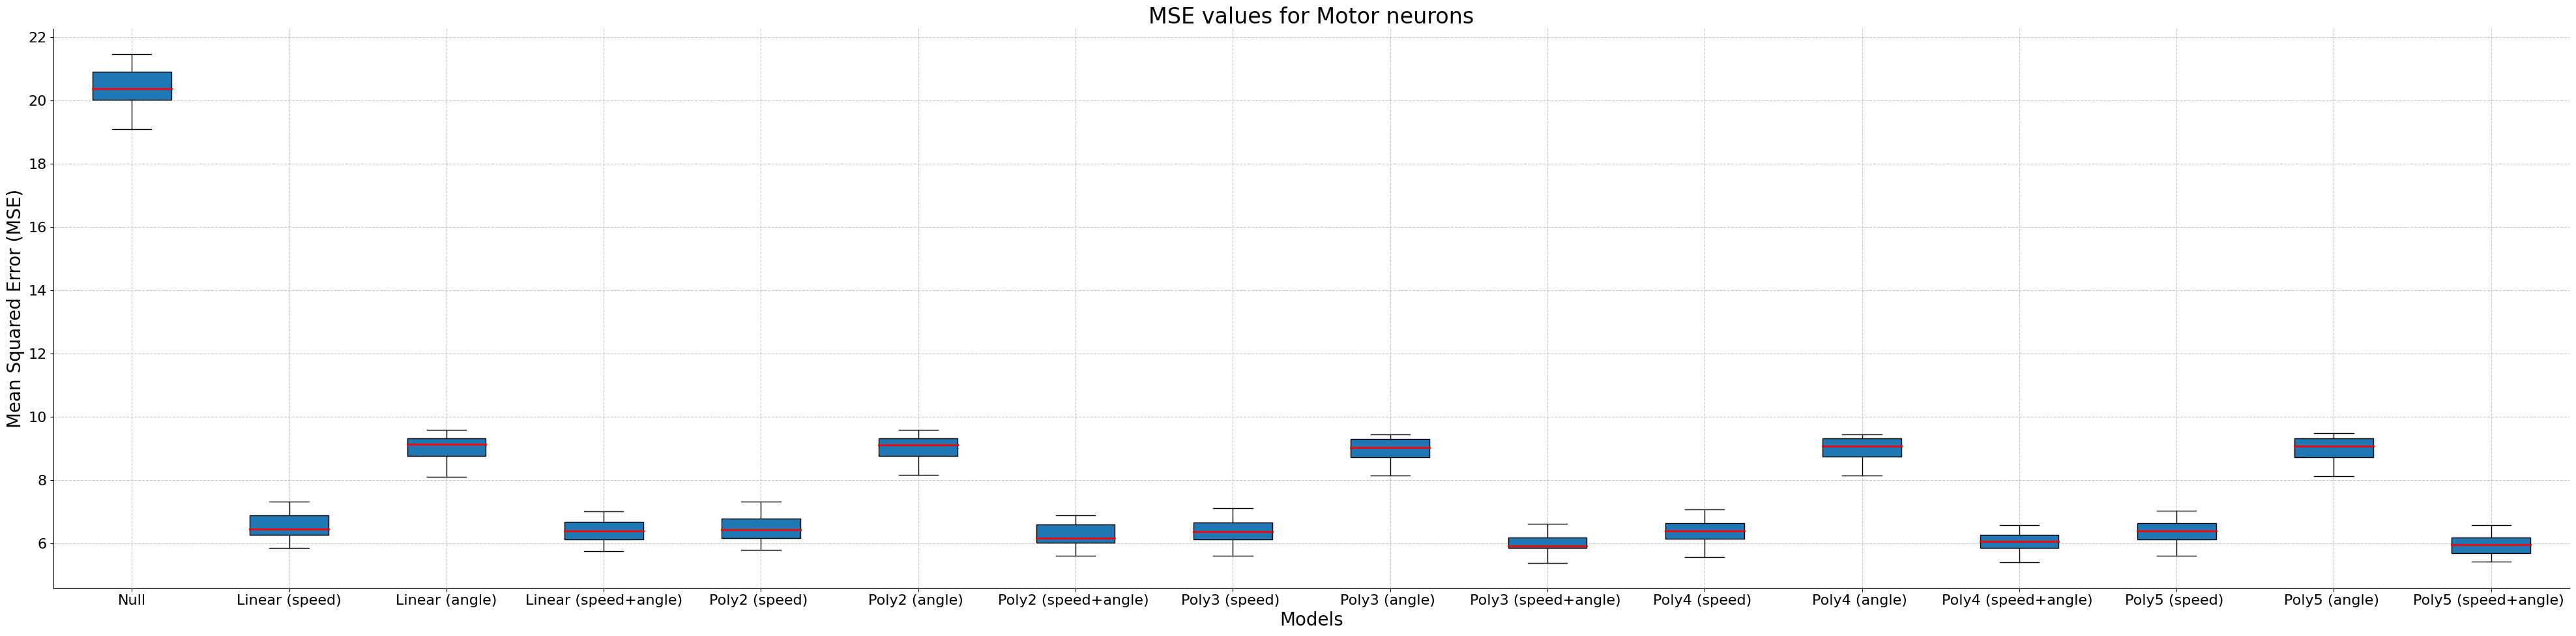

In [ ]:

# Combine the MSE values into a list of lists
all_mse_values = [mse_null_X_motor_pc, mse_motor_lineal_run, mse_motor_lineal_angle, mse_motor_lineal_multinput,
                  mse_motor_poli2_run, mse_motor_poli2_angle, mse_motor_poli2_multinput,
                  mse_motor_poli3_run, mse_motor_poli3_angle, mse_motor_poli3_multinput,
                  mse_motor_poli4_run, mse_motor_poli4_angle, mse_motor_poli4_multinput,
                  mse_motor_poli5_run, mse_motor_poli5_angle, mse_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
plt.boxplot(all_mse_values, labels=['Null','Linear (speed)','Linear (angle)', 'Linear (speed+angle)',
                                    'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ',
                                    'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ',
                                    'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ',
                                    'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '], patch_artist=True,medianprops=dict(color='red', linewidth=2))


# Increase font size
ax.tick_params(axis='both', labelsize=16)

# Make lines from plot ticker darker
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models', fontsize=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.title('MSE values for Motor neurons', fontsize=24)

# Display the plot
plt.show()


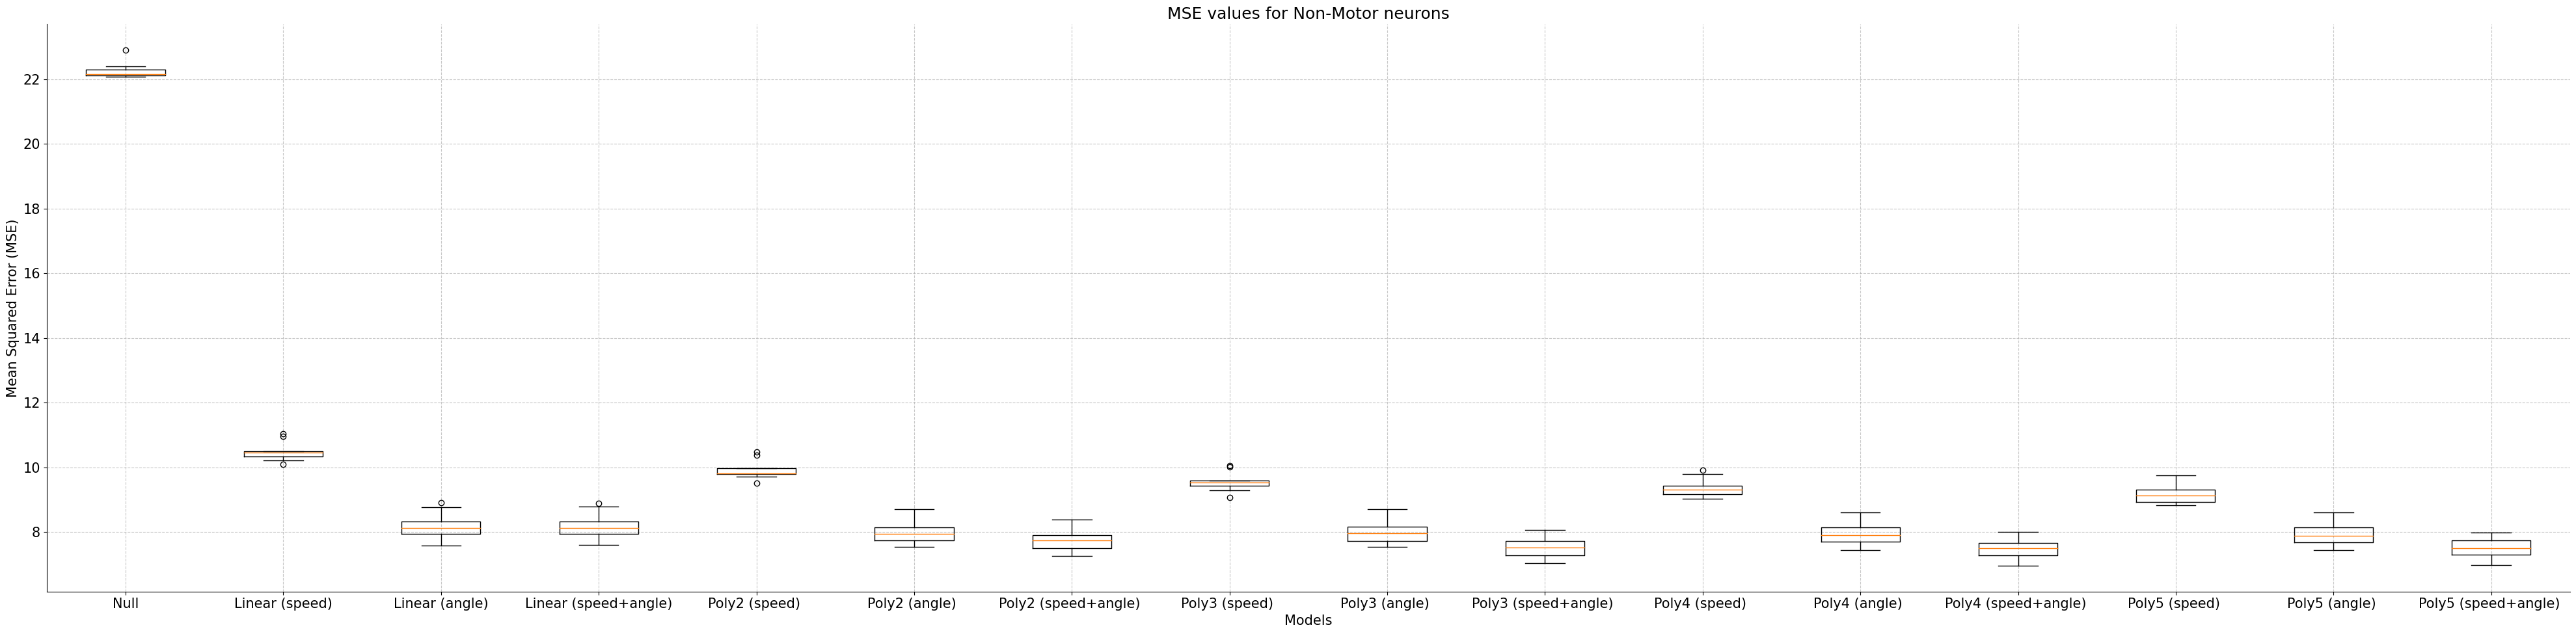

In [ ]:
# Combine the MSE values into a list of lists
#all_mse_values = [mse_null_X_non_motor_pc, mse_non_motor_lineal_angle, mse_non_motor_lineal_multinput, mse_non_motor_poli2_angle, mse_non_motor_poli2_multinput, mse_non_motor_poli3_angle, mse_non_motor_poli3_multinput, mse_non_motor_poli4_angle, mse_non_motor_poli4_multinput, mse_non_motor_poli5_angle, mse_non_motor_poli5_multinput]
all_mse_values = [mse_null_X_non_motor_pc, mse_non_motor_lineal_run,mse_non_motor_lineal_angle, mse_non_motor_lineal_multinput, mse_non_motor_poli2_run,mse_non_motor_poli2_angle, mse_non_motor_poli2_multinput, mse_non_motor_poli3_run,mse_non_motor_poli3_angle, mse_non_motor_poli3_multinput, mse_non_motor_poli4_run,mse_non_motor_poli4_angle, mse_non_motor_poli4_multinput, mse_non_motor_poli5_run,mse_non_motor_poli5_angle, mse_non_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
#plt.boxplot(all_mse_values, labels=['Null','Linear (angle)', 'Linear (speed+angle)', 'Poly2 (angle) ','Poly2 (speed+angle) ', 'Poly3 (angle) ','Poly3 (speed+angle) ', 'Poly4 (angle) ','Poly4 (speed+angle) ', 'Poly5 (angle) ','Poly5 (speed+angle) '])
plt.boxplot(all_mse_values, labels=['Null','Linear (speed)','Linear (angle)', 'Linear (speed+angle)', 'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ', 'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ', 'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ', 'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '])

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE values for Non-Motor neurons')

# Display the plot
plt.show()

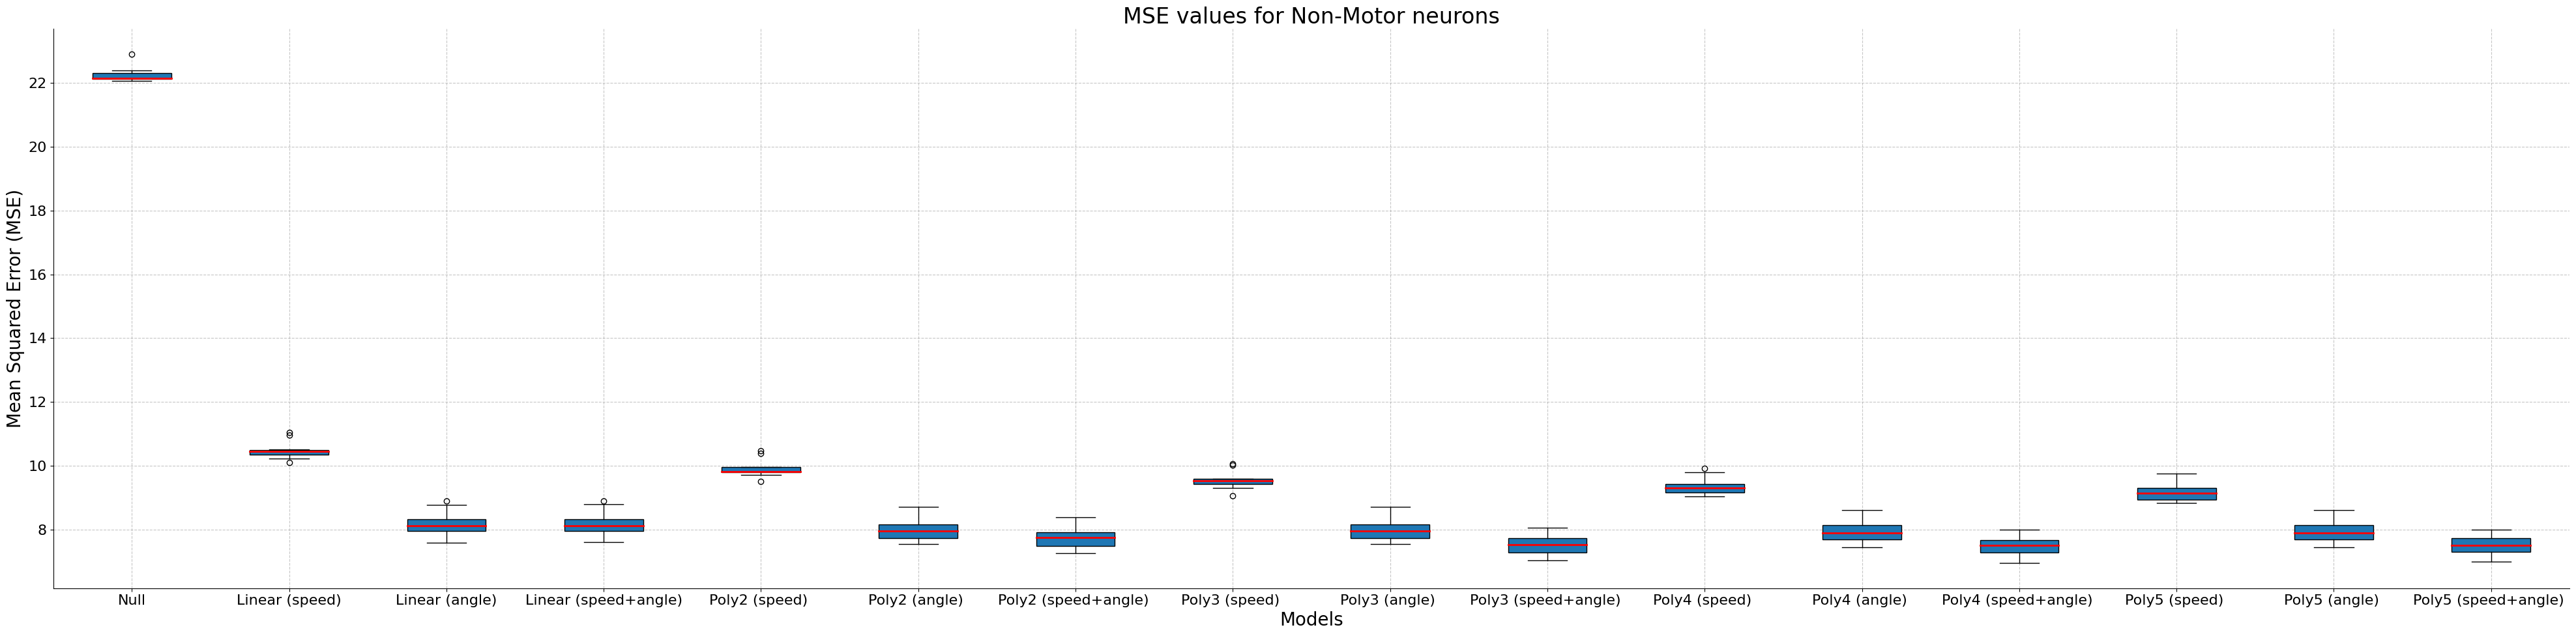

In [ ]:
import matplotlib.pyplot as plt

# Combine the MSE values into a list of lists
all_mse_values = [mse_null_X_non_motor_pc, mse_non_motor_lineal_run, mse_non_motor_lineal_angle, mse_non_motor_lineal_multinput,
                  mse_non_motor_poli2_run, mse_non_motor_poli2_angle, mse_non_motor_poli2_multinput,
                  mse_non_motor_poli3_run, mse_non_motor_poli3_angle, mse_non_motor_poli3_multinput,
                  mse_non_motor_poli4_run, mse_non_motor_poli4_angle, mse_non_motor_poli4_multinput,
                  mse_non_motor_poli5_run, mse_non_motor_poli5_angle, mse_non_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
boxplot = plt.boxplot(all_mse_values, labels=['Null','Linear (speed)','Linear (angle)', 'Linear (speed+angle)',
                                               'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ',
                                               'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ',
                                               'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ',
                                               'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '],
                      patch_artist=True, medianprops=dict(color='red', linewidth=2))

# Increase font size
ax.tick_params(axis='both', labelsize=16)

# Make lines from plot ticker darker
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models', fontsize=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.title('MSE values for Non-Motor neurons', fontsize=24)

# Display the plot
plt.show()


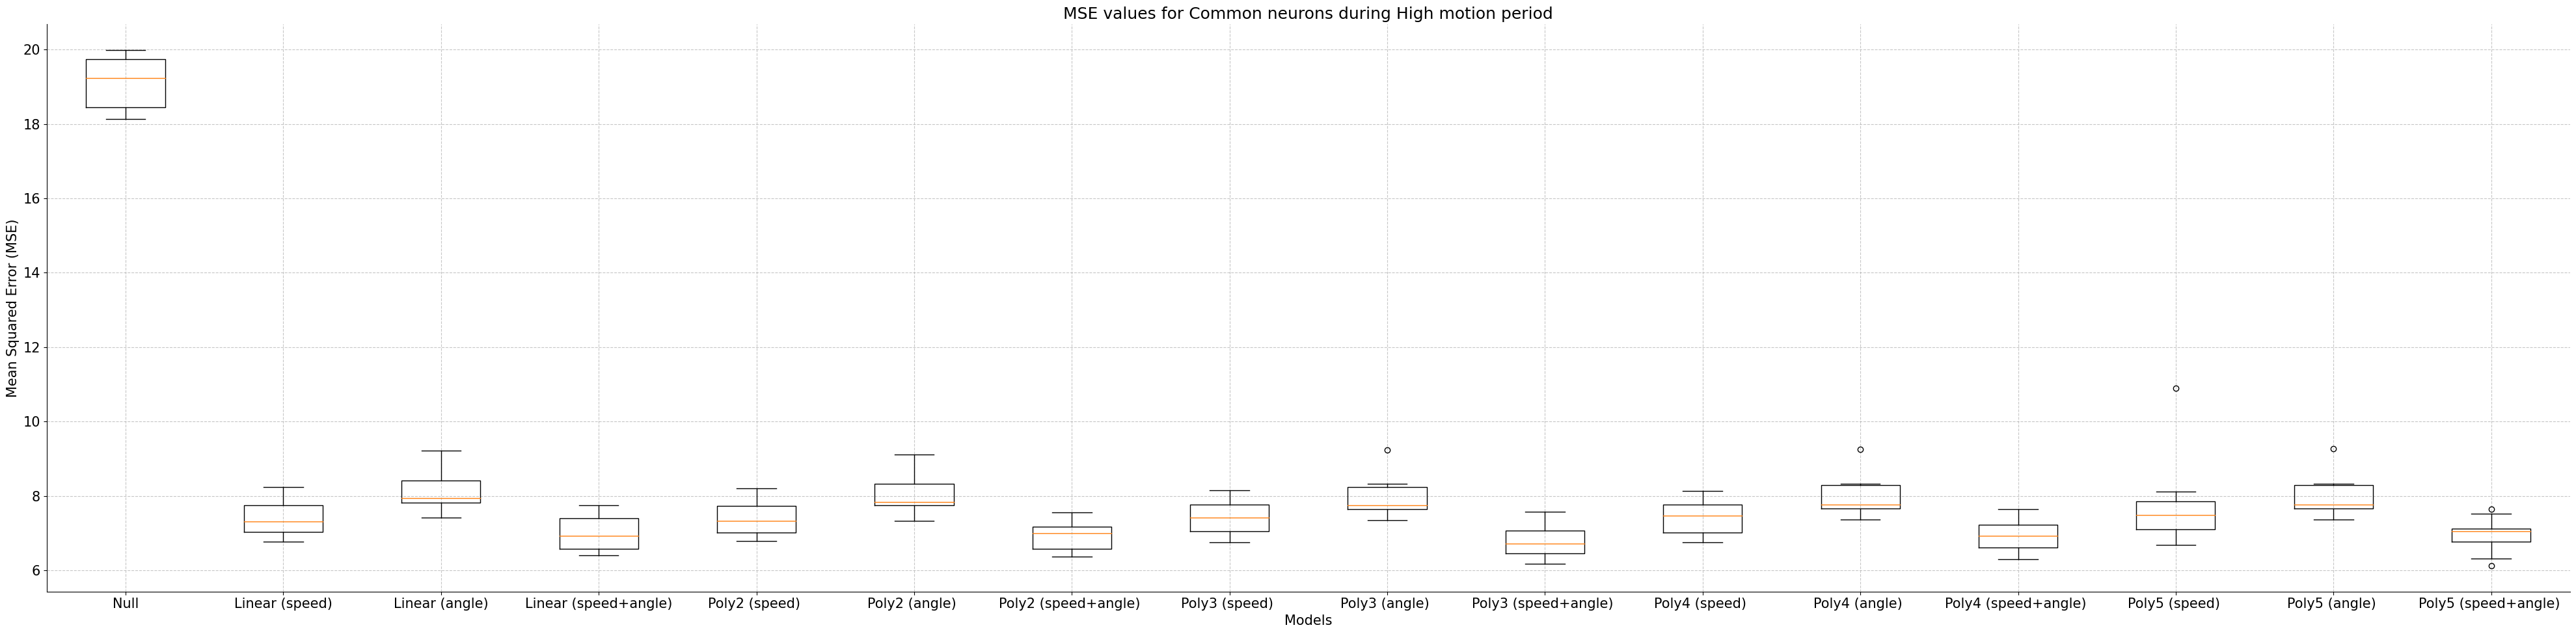

In [ ]:
# Combine the MSE values into a list of lists
#all_mse_values = [mse_null_X_common_motor_pc,mse_common_motor_lineal_run, mse_common_motor_lineal_multinput, mse_common_motor_poli2_run, mse_common_motor_poli2_multinput, mse_common_motor_poli3_run, mse_common_motor_poli3_multinput, mse_common_motor_poli4_run, mse_common_motor_poli4_multinput, mse_common_motor_poli5_run, mse_common_motor_poli5_multinput]
all_mse_values = [mse_null_X_common_motor_pc,mse_common_motor_lineal_run,mse_common_motor_lineal_angle, mse_common_motor_lineal_multinput, mse_common_motor_poli2_run,mse_common_motor_poli2_angle, mse_common_motor_poli2_multinput, mse_common_motor_poli3_run,mse_common_motor_poli3_angle, mse_common_motor_poli3_multinput, mse_common_motor_poli4_run,mse_common_motor_poli4_angle, mse_common_motor_poli4_multinput, mse_common_motor_poli5_run,mse_common_motor_poli5_angle, mse_common_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
#plt.boxplot(all_mse_values, labels=['Null','Linear (speed)', 'Linear (speed+angle)', 'Poly2 (speed) ','Poly2 (speed+angle) ', 'Poly3 (speed) ','Poly3 (speed+angle) ', 'Poly4 (speed) ','Poly4 (speed+angle) ', 'Poly5 (speed) ','Poly5 (speed+angle) '])
plt.boxplot(all_mse_values, labels=['Null','Linear (speed)','Linear (angle)', 'Linear (speed+angle)', 'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ', 'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ', 'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ', 'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '])

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE values for Common neurons during High motion period')

# Display the plot
plt.show()

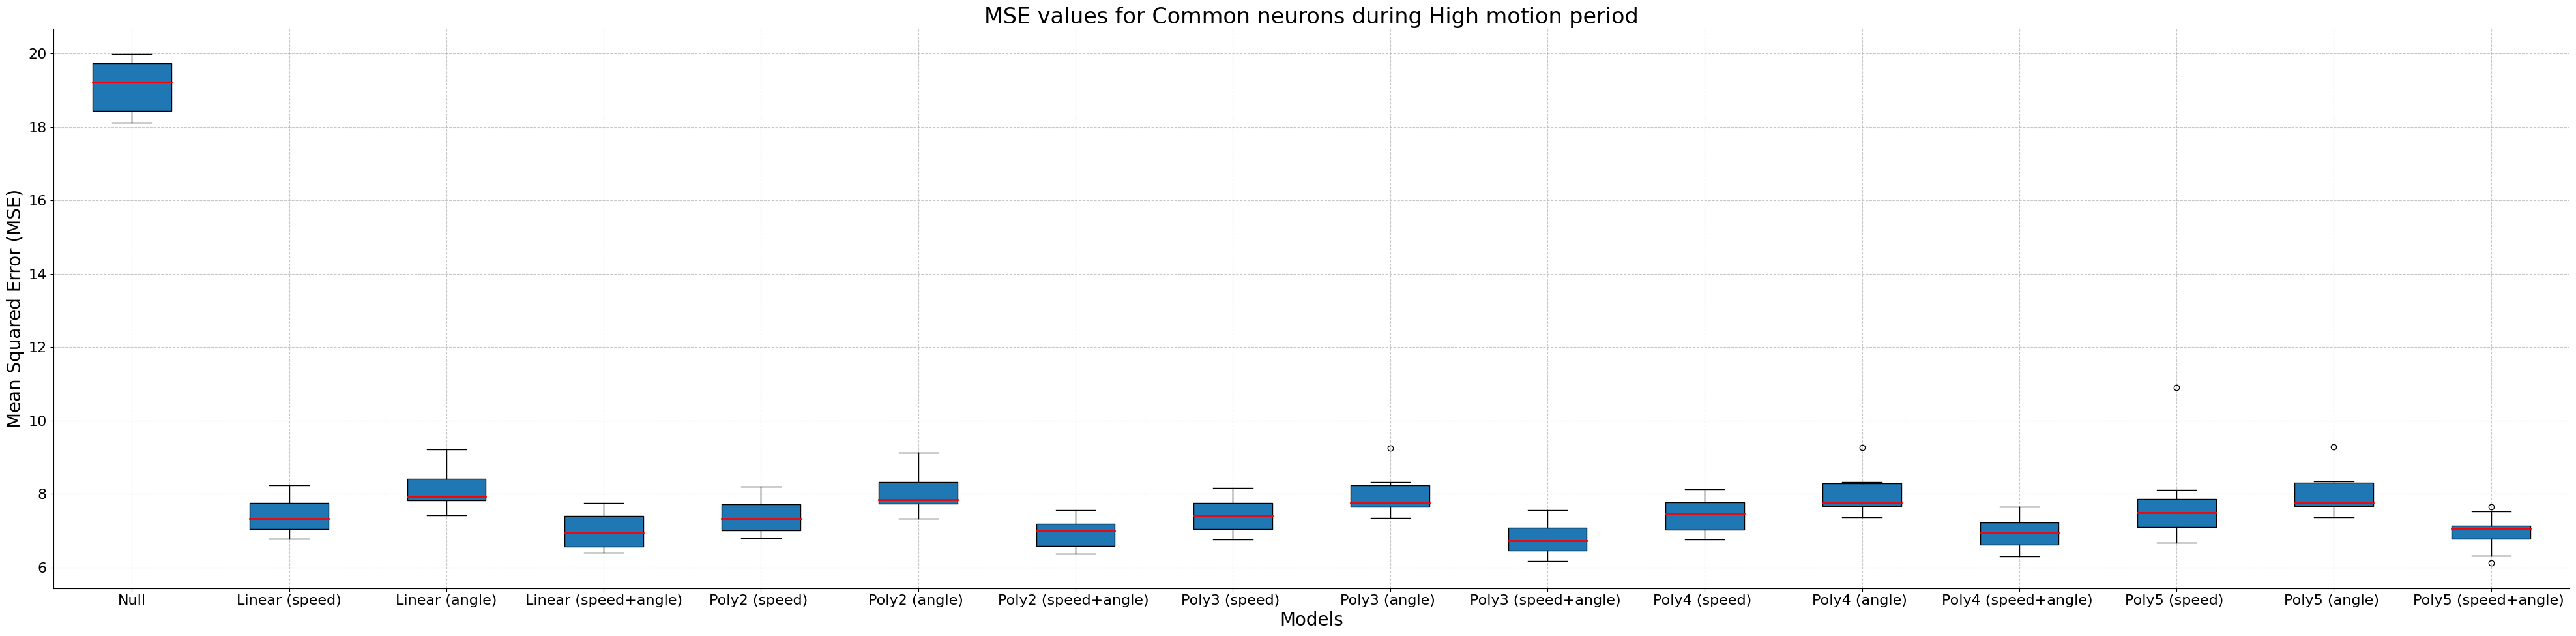

In [ ]:
import matplotlib.pyplot as plt

# Combine the MSE values into a list of lists
all_mse_values = [mse_null_X_common_motor_pc, mse_common_motor_lineal_run, mse_common_motor_lineal_angle, mse_common_motor_lineal_multinput,
                  mse_common_motor_poli2_run, mse_common_motor_poli2_angle, mse_common_motor_poli2_multinput,
                  mse_common_motor_poli3_run, mse_common_motor_poli3_angle, mse_common_motor_poli3_multinput,
                  mse_common_motor_poli4_run, mse_common_motor_poli4_angle, mse_common_motor_poli4_multinput,
                  mse_common_motor_poli5_run, mse_common_motor_poli5_angle, mse_common_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
boxplot = plt.boxplot(all_mse_values, labels=['Null','Linear (speed)', 'Linear (angle)', 'Linear (speed+angle)',
                                               'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ',
                                               'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ',
                                               'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ',
                                               'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '],
                      patch_artist=True, medianprops=dict(color='red', linewidth=2))

# Increase font size
ax.tick_params(axis='both', labelsize=16)

# Make lines from plot ticker darker
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models', fontsize=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.title('MSE values for Common neurons during High motion period', fontsize=24)

# Display the plot
plt.show()


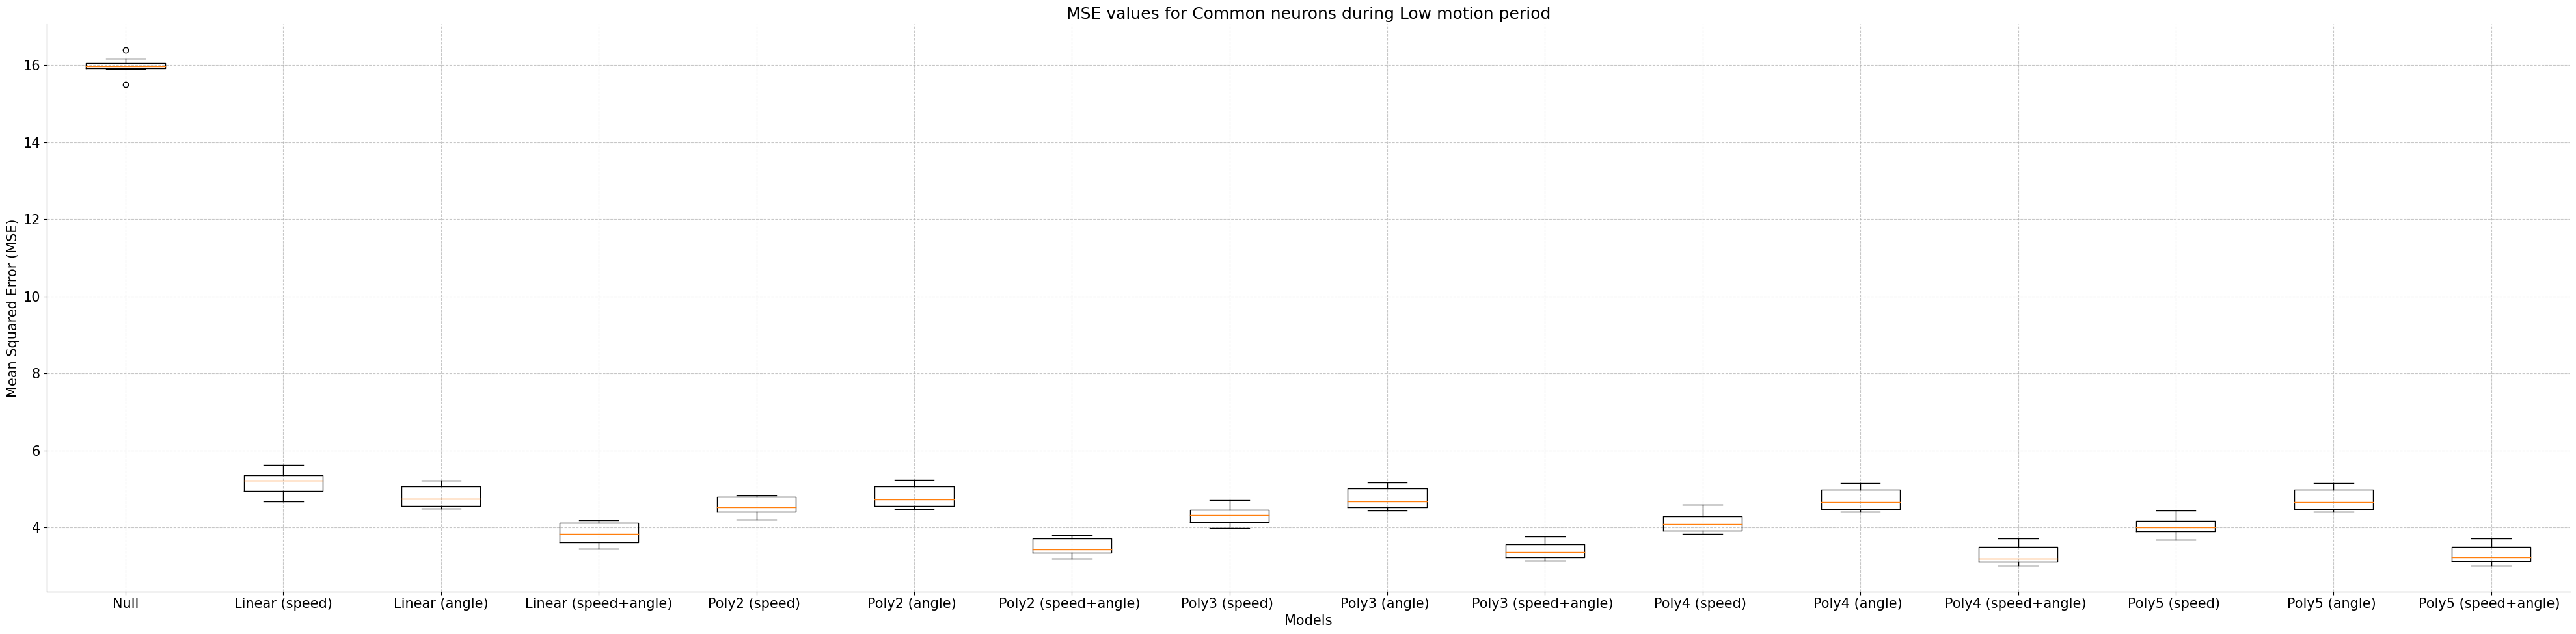

In [ ]:
# Combine the MSE values into a list of lists
#all_mse_values = [mse_null_X_common_non_motor_pc,mse_common_non_motor_lineal_angle, mse_common_non_motor_lineal_multinput, mse_common_non_motor_poli2_angle, mse_common_non_motor_poli2_multinput, mse_common_non_motor_poli3_angle, mse_common_non_motor_poli3_multinput, mse_common_non_motor_poli4_angle, mse_common_non_motor_poli4_multinput, mse_common_non_motor_poli5_angle, mse_common_non_motor_poli5_multinput]
all_mse_values = [mse_null_X_common_non_motor_pc,mse_common_non_motor_lineal_run,mse_common_non_motor_lineal_angle, mse_common_non_motor_lineal_multinput, mse_common_non_motor_poli2_run,mse_common_non_motor_poli2_angle, mse_common_non_motor_poli2_multinput, mse_common_non_motor_poli3_run,mse_common_non_motor_poli3_angle, mse_common_non_motor_poli3_multinput, mse_common_non_motor_poli4_run,mse_common_non_motor_poli4_angle, mse_common_non_motor_poli4_multinput, mse_common_non_motor_poli5_run,mse_common_non_motor_poli5_angle, mse_common_non_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
#plt.boxplot(all_mse_values, labels=['Null','Linear (angle)', 'Linear (speed+angle)', 'Poly2 (angle) ','Poly2 (speed+angle) ', 'Poly3 (angle) ','Poly3 (speed+angle) ', 'Poly4 (angle) ','Poly4 (speed+angle) ', 'Poly5 (angle) ','Poly5 (speed+angle) '])
plt.boxplot(all_mse_values, labels=['Null','Linear (speed)','Linear (angle)', 'Linear (speed+angle)', 'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ', 'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ', 'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ', 'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '])

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE values for Common neurons during Low motion period')

# Display the plot
plt.show()

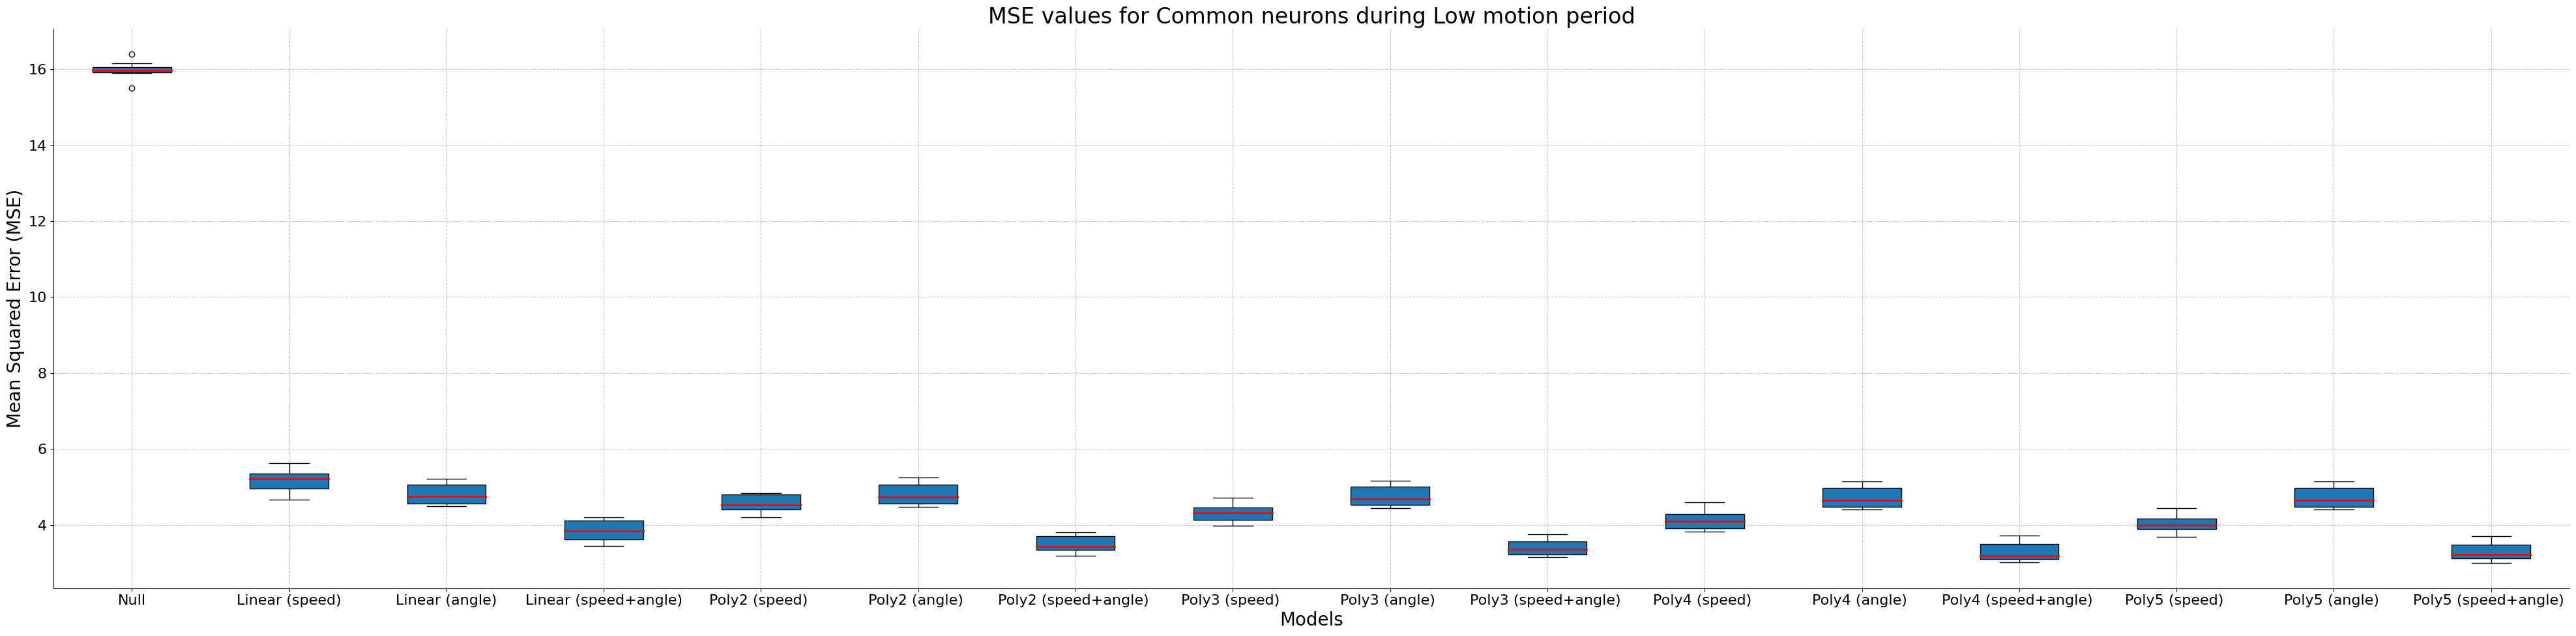

In [ ]:
import matplotlib.pyplot as plt

# Combine the MSE values into a list of lists
all_mse_values = [mse_null_X_common_non_motor_pc, mse_common_non_motor_lineal_run, mse_common_non_motor_lineal_angle, mse_common_non_motor_lineal_multinput,
                  mse_common_non_motor_poli2_run, mse_common_non_motor_poli2_angle, mse_common_non_motor_poli2_multinput,
                  mse_common_non_motor_poli3_run, mse_common_non_motor_poli3_angle, mse_common_non_motor_poli3_multinput,
                  mse_common_non_motor_poli4_run, mse_common_non_motor_poli4_angle, mse_common_non_motor_poli4_multinput,
                  mse_common_non_motor_poli5_run, mse_common_non_motor_poli5_angle, mse_common_non_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
boxplot = plt.boxplot(all_mse_values, labels=['Null','Linear (speed)', 'Linear (angle)', 'Linear (speed+angle)',
                                               'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ',
                                               'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ',
                                               'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ',
                                               'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '],
                      patch_artist=True, medianprops=dict(color='red', linewidth=2))

# Increase font size
ax.tick_params(axis='both', labelsize=16)

# Make lines from plot ticker darker
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models', fontsize=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.title('MSE values for Common neurons during Low motion period', fontsize=24)

# Display the plot
plt.show()


Stimulation condition (FOR REFERENCE ONLY)

Motor neurons
The best model is: Poly 5 Multi with MSE: 3.826427193909042

Non-motor neurons during low motion period
The best model is: Poly 5 Angle with MSE: 3.658769329871377

Common neurons during high motion period
The best model is: Poly 5 Multi with MSE: 6.464288806153952

Common neurons during low motion period
The best model is: Poly 4 Multi with MSE: 6.7487700798680414




Spontaneous COndition (This script)

motor neurons

The best model is: Poly 3 Multi with MSE: 5.924569818084482

common neurons during high motion period

The best model is: Poly 3 Multi with MSE: 6.724156029194141

common neurons during low motion period

The best model is: Poly 4 Multi with MSE: 3.1966769413931515

non-motor neurons during low motion period

\The best model is: Poly 4 Multi with MSE: 7.497597334595136

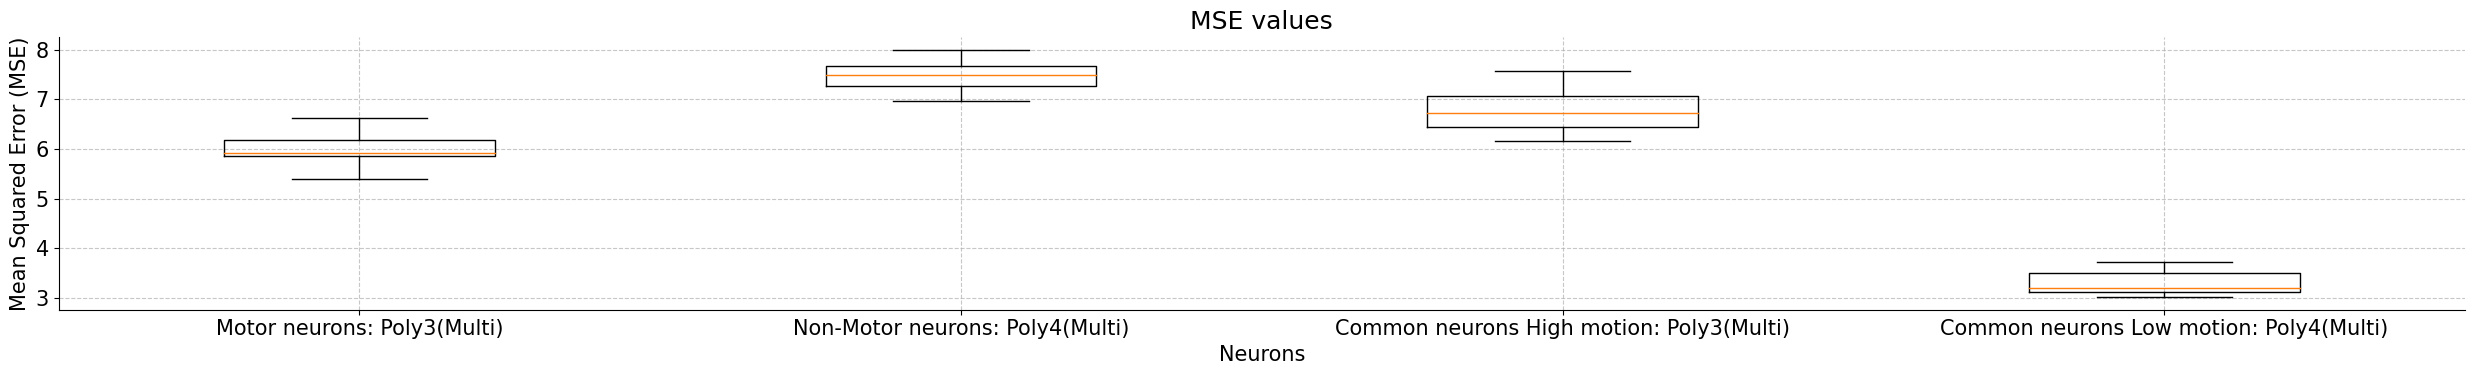

In [ ]:
all_mse_values=[ mse_motor_poli3_multinput, mse_non_motor_poli4_multinput, mse_common_motor_poli3_multinput ,mse_common_non_motor_poli4_multinput]
fig, ax = plt.subplots(figsize=(25, 4))
# Create a boxplot for all models
plt.boxplot(all_mse_values, labels=['Motor neurons: Poly3(Multi)', 'Non-Motor neurons: Poly4(Multi)', 'Common neurons High motion: Poly3(Multi)','Common neurons Low motion: Poly4(Multi)'])
ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Neurons')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE values')

# Display the plot
plt.show()

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/Stringer"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
np.save('/content/drive/My Drive/Stringer/all_mse_values_spontaneous.npy', all_mse_values)

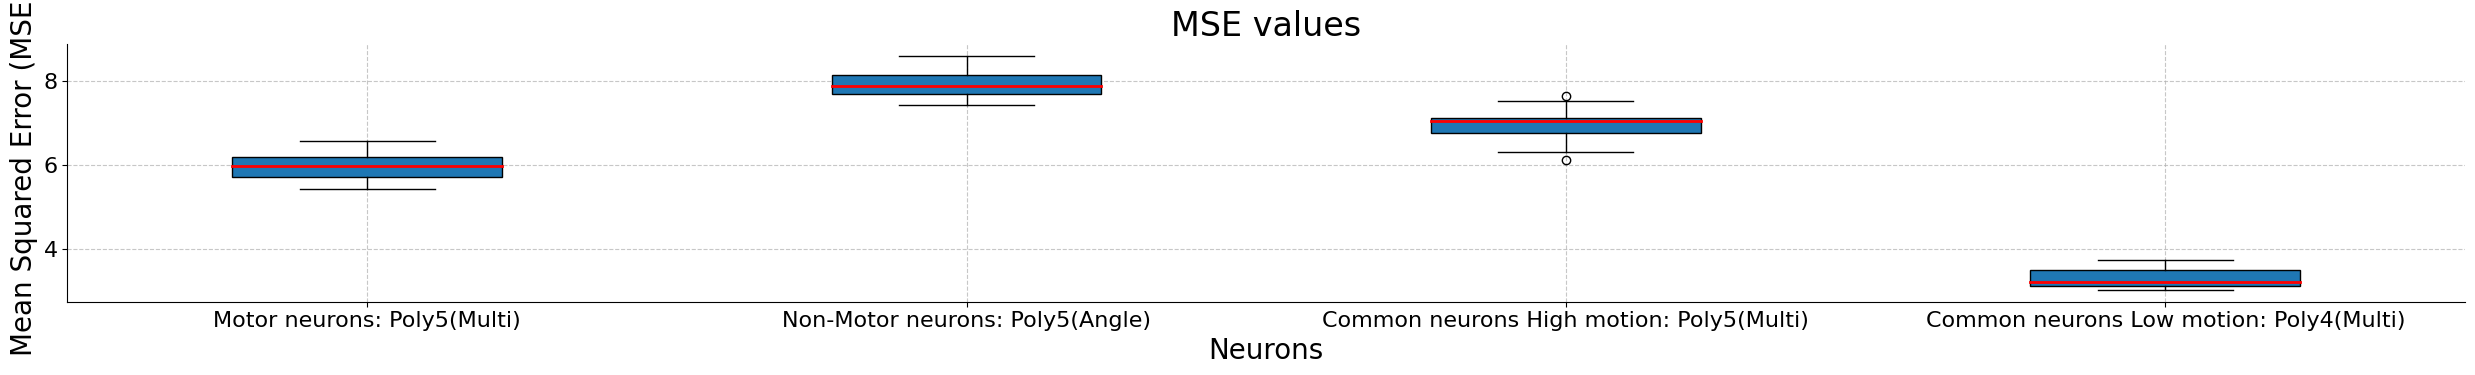

In [ ]:
import matplotlib.pyplot as plt

# Combine the MSE values into a list of lists
all_mse_values = [mse_motor_poli5_multinput, mse_non_motor_poli5_angle, mse_common_motor_poli5_multinput, mse_common_non_motor_poli4_multinput]

fig, ax = plt.subplots(figsize=(25, 4))
# Create a boxplot for all models
boxplot = plt.boxplot(all_mse_values, labels=['Motor neurons: Poly5(Multi)', 'Non-Motor neurons: Poly5(Angle)', 'Common neurons High motion: Poly5(Multi)','Common neurons Low motion: Poly4(Multi)'],
                      patch_artist=True, medianprops=dict(color='red', linewidth=2))

# Increase font size
ax.tick_params(axis='both', labelsize=16)

# Make lines from plot ticker darker
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Neurons', fontsize=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.title('MSE values', fontsize=24)

# Display the plot
plt.show()


In [ ]:
print('Mptor neurons',np.median(mse_motor_poli5_multinput))
print('Non-Mptor neurons',np.median(mse_non_motor_poli5_angle))


Mptor neurons 5.9708118995302275
Non-Mptor neurons 7.891928334815978


In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions in Common neurons during High-motion periods

ncomp = 3  # try 2, then try 3
xinit = 3 * zscore(X_common_motor [:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=25,
             metric='correlation', transform_seed=42).fit_transform(X_common_motor)


In [ ]:
print(embed.shape)

(999, 3)


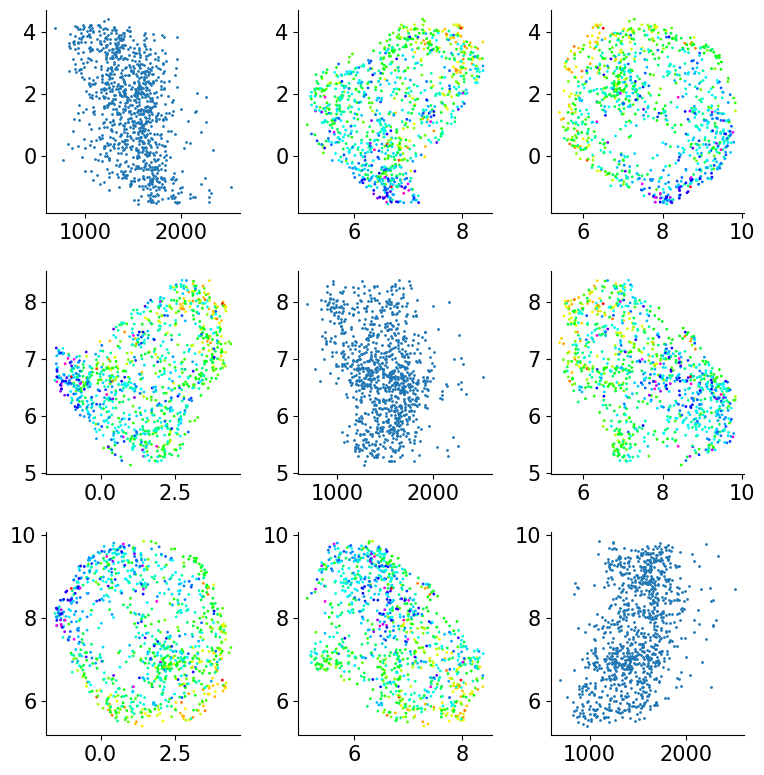

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i == j:
      plt.scatter(high_motion_angle_data, embed[:, i], s=1)
    else:
      plt.scatter(embed[:, j], embed[:, i], s=1, c=high_motion_angle_data, cmap='hsv')
plt.show()

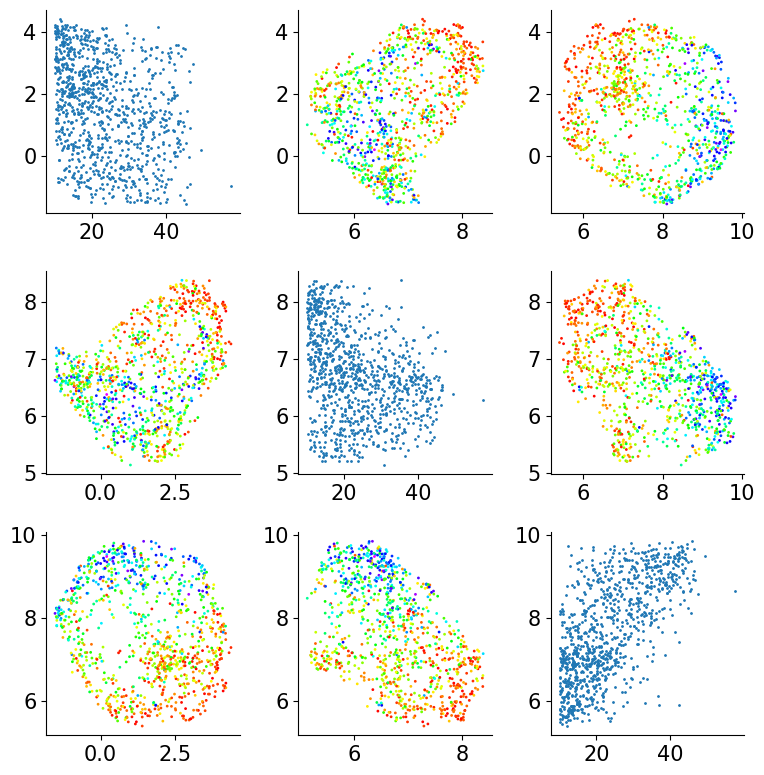

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i == j:
      plt.scatter(high_motion_run_data, embed[:, i], s=1)
    else:
      plt.scatter(embed[:, j], embed[:, i], s=1, c=high_motion_run_data, cmap='hsv')
plt.show()

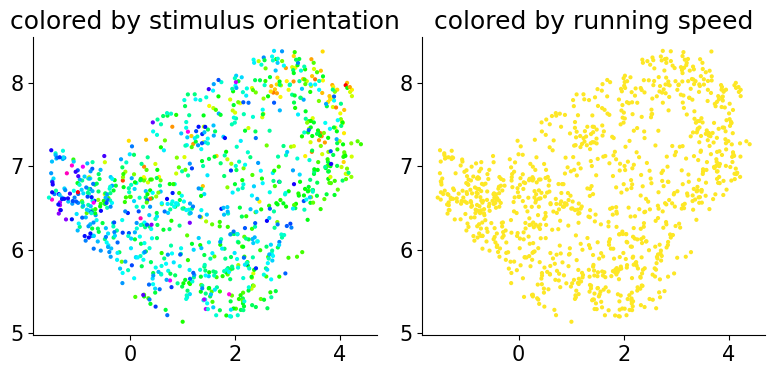

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(embed[:, 0], embed[:, 1], s=4, c=high_motion_angle_data, cmap='hsv')
plt.title('colored by stimulus orientation')

plt.subplot(1, 2, 2)
plt.scatter(embed[:, 0], embed[:, 1], s=4, c=high_motion_run_data, vmin=0, vmax=10)
plt.title('colored by running speed')
plt.show()

In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions in Motor neurons during High-motion periods

ncomp = 3  # try 2, then try 3
xinit = 3 * zscore(X_motor [:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=25,
             metric='correlation', transform_seed=42).fit_transform(X_motor)


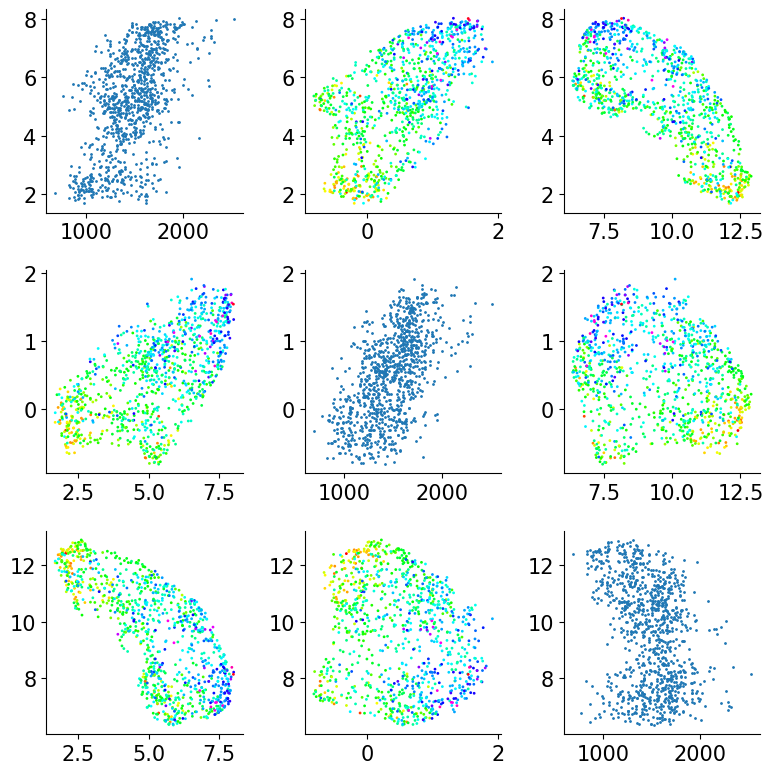

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i == j:
      plt.scatter(high_motion_angle_data, embed[:, i], s=1)
    else:
      plt.scatter(embed[:, j], embed[:, i], s=1, c=high_motion_angle_data, cmap='hsv')
plt.show()

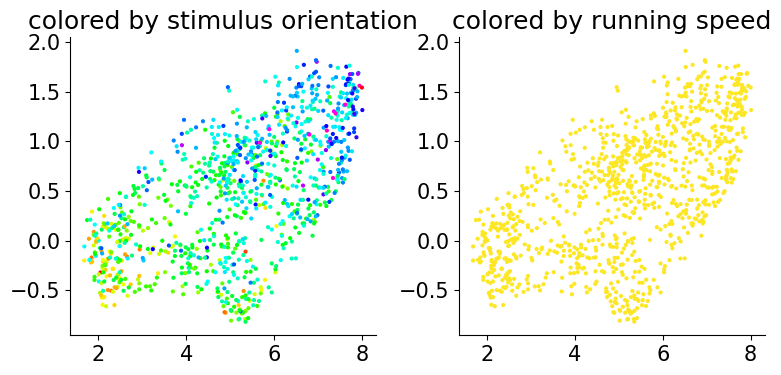

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(embed[:, 0], embed[:, 1], s=4, c=high_motion_angle_data, cmap='hsv')
plt.title('colored by stimulus orientation')

plt.subplot(1, 2, 2)
plt.scatter(embed[:, 0], embed[:, 1], s=4, c=high_motion_run_data, vmin=0, vmax=10)
plt.title('colored by running speed')
plt.show()

In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions in Common neurons during Low-motion periods

ncomp = 3  # try 2, then try 3
xinit = 3 * zscore(X_common_non_motor [:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=25,
             metric='correlation', transform_seed=42).fit_transform(X_common_non_motor)


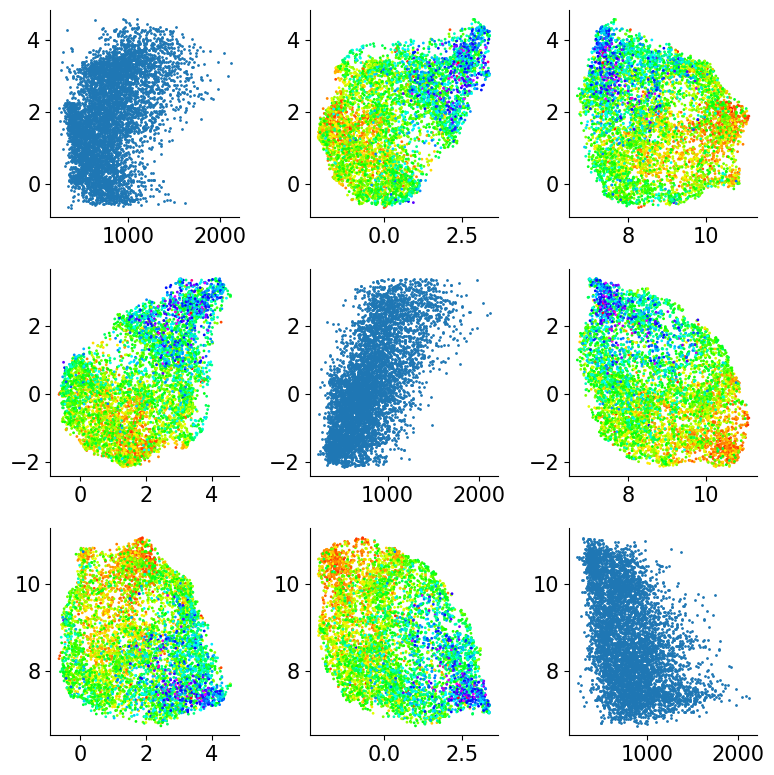

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i == j:
      plt.scatter(non_motion_angle_data , embed[:, i], s=1)
    else:
      plt.scatter(embed[:, j], embed[:, i], s=1, c=non_motion_angle_data, cmap='hsv')
plt.show()

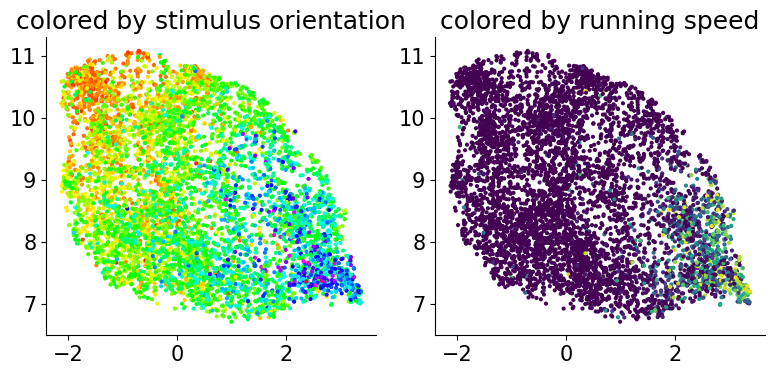

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(embed[:, 1], embed[:, 2], s=4, c=non_motion_angle_data, cmap='hsv')
plt.title('colored by stimulus orientation')

plt.subplot(1, 2, 2)
plt.scatter(embed[:, 1], embed[:, 2], s=4, c=non_motion_run_data, vmin=0, vmax=10)
plt.title('colored by running speed')
plt.show()

(array([5114.,  192.,  105.,  119.,  105.,   85.,   88.,   72.,   71.,
          68.]),
 array([0.        , 0.99758631, 1.99517262, 2.99275893, 3.99034523,
        4.98793154, 5.98551785, 6.98310416, 7.98069047, 8.97827678,
        9.97586309]),
 <BarContainer object of 10 artists>)

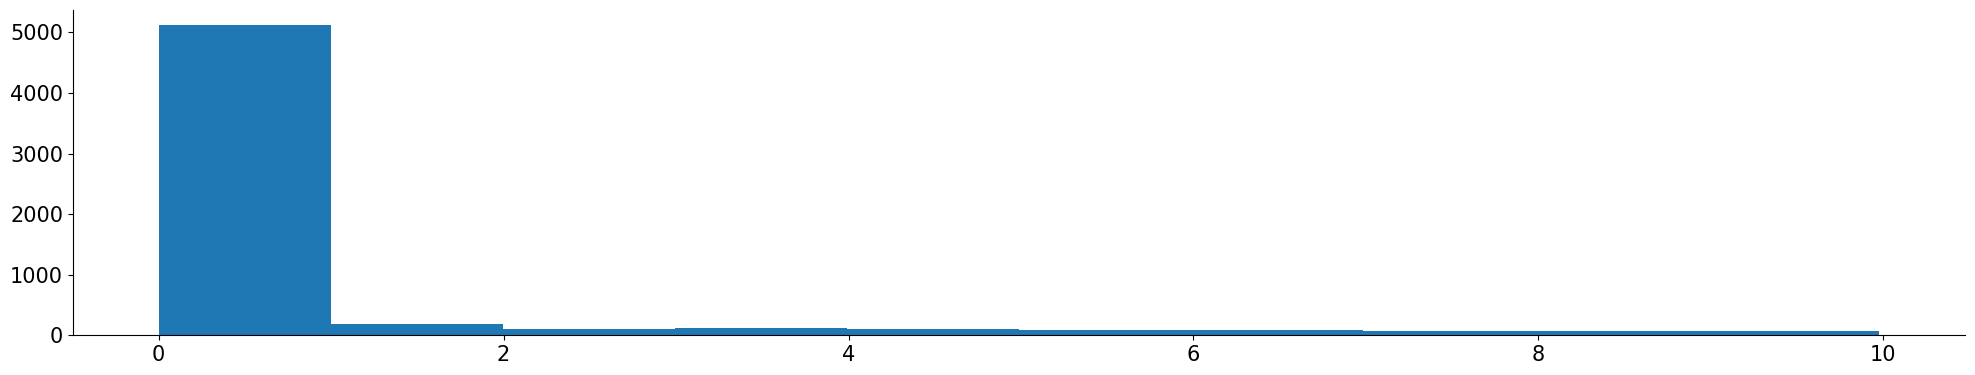

In [ ]:
plt.hist(non_motion_run_data)

In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions in Non-motor neurons during Low-motion periods

ncomp = 3  # try 2, then try 3
xinit = 3 * zscore(X_non_motor [:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=25,
             metric='correlation', transform_seed=42).fit_transform(X_non_motor)


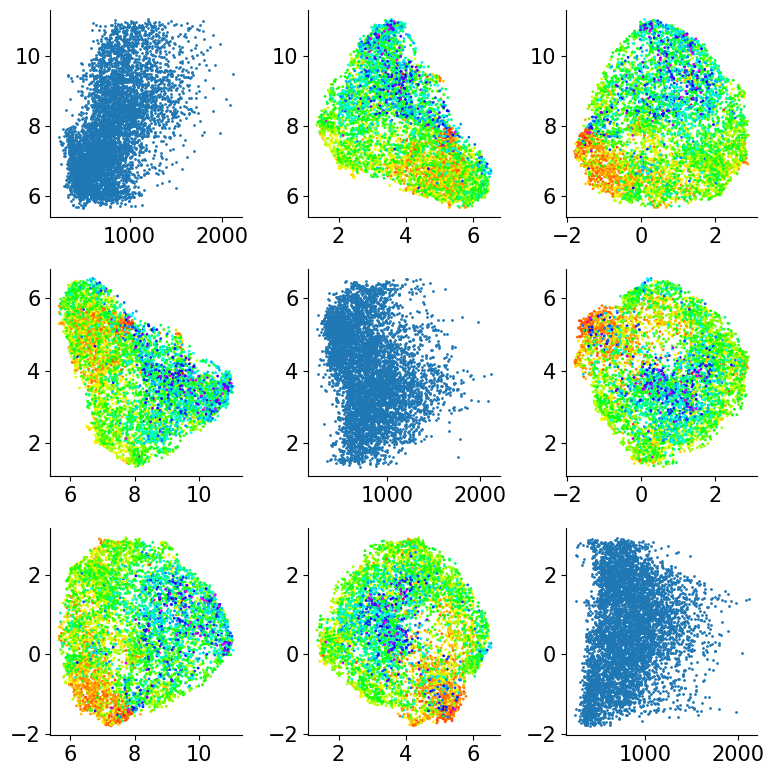

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i == j:
      plt.scatter(non_motion_angle_data , embed[:, i], s=1)
    else:
      plt.scatter(embed[:, j], embed[:, i], s=1, c=non_motion_angle_data, cmap='hsv')
plt.show()

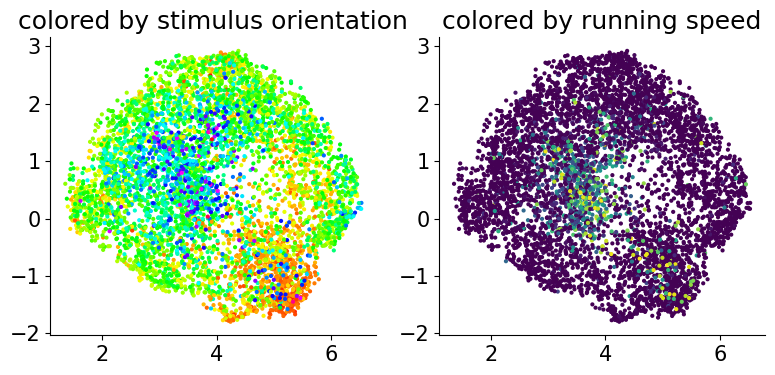

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(embed[:, 1], embed[:, 2], s=4, c=non_motion_angle_data, cmap='hsv')
plt.title('colored by stimulus orientation')

plt.subplot(1, 2, 2)
plt.scatter(embed[:, 1], embed[:, 2], s=4, c=non_motion_run_data, vmin=0, vmax=10)
plt.title('colored by running speed')
plt.show()

In [ ]:
embed = embed.flatten()
isort = np.argsort(embed)
RasterMap = uniform_filter1d(Z[isort, :], size=50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis=1)

IndexError: index 7808 is out of bounds for axis 0 with size 92

In [ ]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin=-1, aspect='auto', cmap='gray_r')
ax.set(xlabel='timepoints', ylabel='sorted neurons')
plt.show()

In [ ]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture